In [1]:
path= '/Users/daxfeliz/Desktop/Mentoring_Teaching/SRMP_project/2024_SRMP/'
print(path)
import os,sys
sys.path.append(path)

/Users/daxfeliz/Desktop/Mentoring_Teaching/SRMP_project/2024_SRMP/


In [2]:
from lightcurve_practice_code import extract_TESS_photometry

In [3]:
newpath = os.getcwd()+'/smoothing_practice/'

In [4]:
if os.path.exists(newpath)==False:
    os.mkdir(newpath)
else:
    print(newpath,'exists!')


/Users/daxfeliz/Desktop/Mentoring_Teaching/SRMP_project/2024_SRMP/smoothing_practice/ exists!


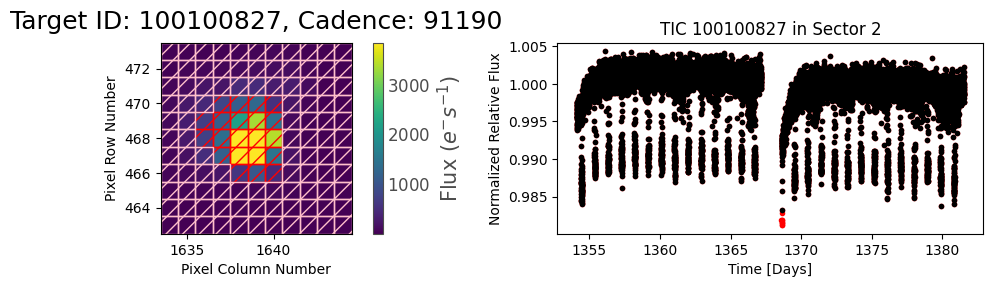

In [5]:
# ID = 200322593
# starname='TIC'+str(ID) #TOI-540

ID = 100100827
starname='TIC '+str(ID) #WASP-18
author='SPOC'
nsigma=2
save_directory=newpath
mask_threshold=7.5

lc=extract_TESS_photometry(starname,author,nsigma,save_directory,mask_threshold)

In [6]:
type(lc)

lightkurve.lightcurve.LightCurve

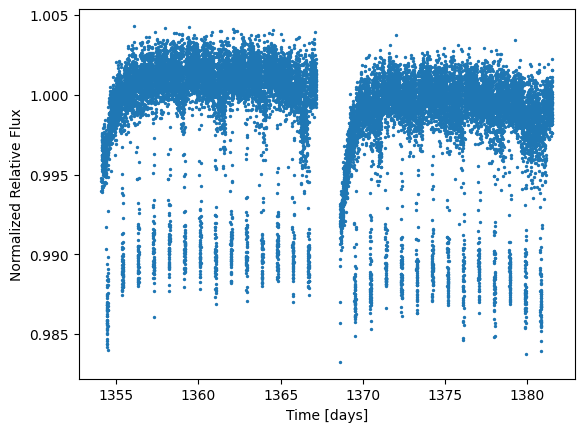

In [7]:
import matplotlib.pyplot as plt 

plt.scatter(lc.time.value,lc.flux.value,s=2)
plt.xlabel('Time [days]')
plt.ylabel('Normalized Relative Flux')
plt.show()



# Now that we have a lightcurve with a rotation signal (sine-like wave signal), we are going to practice using "lightkurve" to smooth this function to remove this rotation signal.

## Lightkurve's "flatten" function uses a Savitsky-Golay filter, which fits a N-th order polynomial for a given window of time. 

# Below, we are going to try different window sizes with a 3rd order polynomial to see how it affects the rotation signal AND the transits that exist within WASP-18's light curve

In [8]:
#NOTE: window lengths MUST be odd (for mathy reasons...)

newlc1,trend1 = lc.flatten(window_length=31,polyorder=3,return_trend=True)
newlc2,trend2 = lc.flatten(window_length=101,polyorder=3,return_trend=True)
newlc3,trend3 = lc.flatten(window_length=301,polyorder=3,return_trend=True)
newlc4,trend4 = lc.flatten(window_length=1001,polyorder=3,return_trend=True)
newlc5,trend5 = lc.flatten(window_length=3001,polyorder=3,return_trend=True)

# Before we get into this, how can we algorithmically measure rotation signals?

## One approximation for stellar rotation's light curve feature is to assume it is like a sine-wave. One type of algorithm that is really good at detecting sine waves is a Lomb-Scargle algorithm. This basically finds what period in time corresponds to sine-like features lining up in phase-space. We can use lightkurve to do Lomb-Scargle searches too!

### For more info, see https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html

# Let's start with a simulated sine wave:

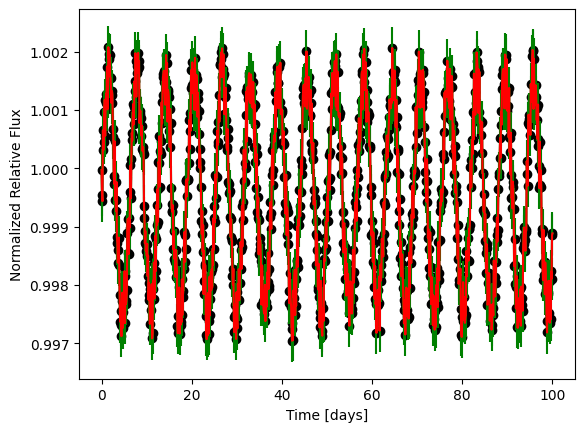

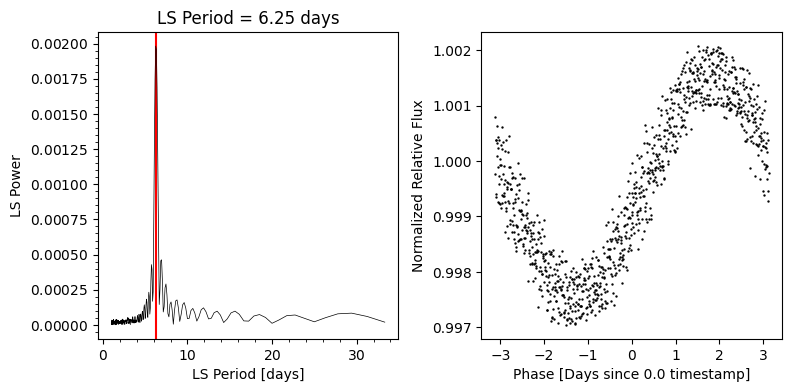

In [9]:
import numpy as np
number_of_points=1000
x=np.linspace(0,100,number_of_points)
y = np.sin(x)


random_noise = 0.55 * np.random.random(size=number_of_points)-[0.5]
y=(y+random_noise)*1/(5e2)
y=y+1

z = np.ones_like(y)*0.25*np.nanstd(y) #array of y-uncertainties with len(y) data points

plt.plot(x,y,'r-',zorder=10)
plt.errorbar(x=x,y=y,yerr=z,color='green')
plt.scatter(x,y,color='black')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Relative Flux')
plt.show()

#convery x,y,z to lightkurve's LightCurve object
import lightkurve as lk
sim_lc = lk.LightCurve(time=x,flux=y,flux_err=z)

min_period=1
max_period=(np.max(sim_lc.time.value)-np.min(sim_lc.time.value))/3
sim_LS = sim_lc.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)

# most-likely rotation period from lomb-scargle periodogram
sim_LS_period=sim_LS.period_at_max_power.value


# let's plot up the results!
import numpy as np


fig=plt.figure(figsize=(8,4))
rows=1
columns=2
ax0 = fig.add_subplot(rows, columns, 1)
ax0b = fig.add_subplot(rows, columns, 2)

sim_LS.plot(ax=ax0,color='black')
ax0.axvline(x=sim_LS_period,color='red',zorder=-10)
ax0.set_title('LS Period = '+str(np.round(sim_LS_period,3))+' days')
ax0.set_xlabel('LS Period [days]')
ax0.set_ylabel('LS Power')
sim_lc.fold(period=sim_LS_period,epoch_time=np.min(sim_lc.time.value)).scatter(s=2,ax=ax0b,color='black')
ax0b.set_xlabel('Phase [Days since '+str(np.round(np.min(sim_lc.time.value)))+' timestamp]')
ax0b.set_ylabel('Normalized Relative Flux')

fig.tight_layout(pad=1)
plt.show()

# Now that we have a way of detecting this sinusoid with lomb-scargle, how does smoothing affect this signal?

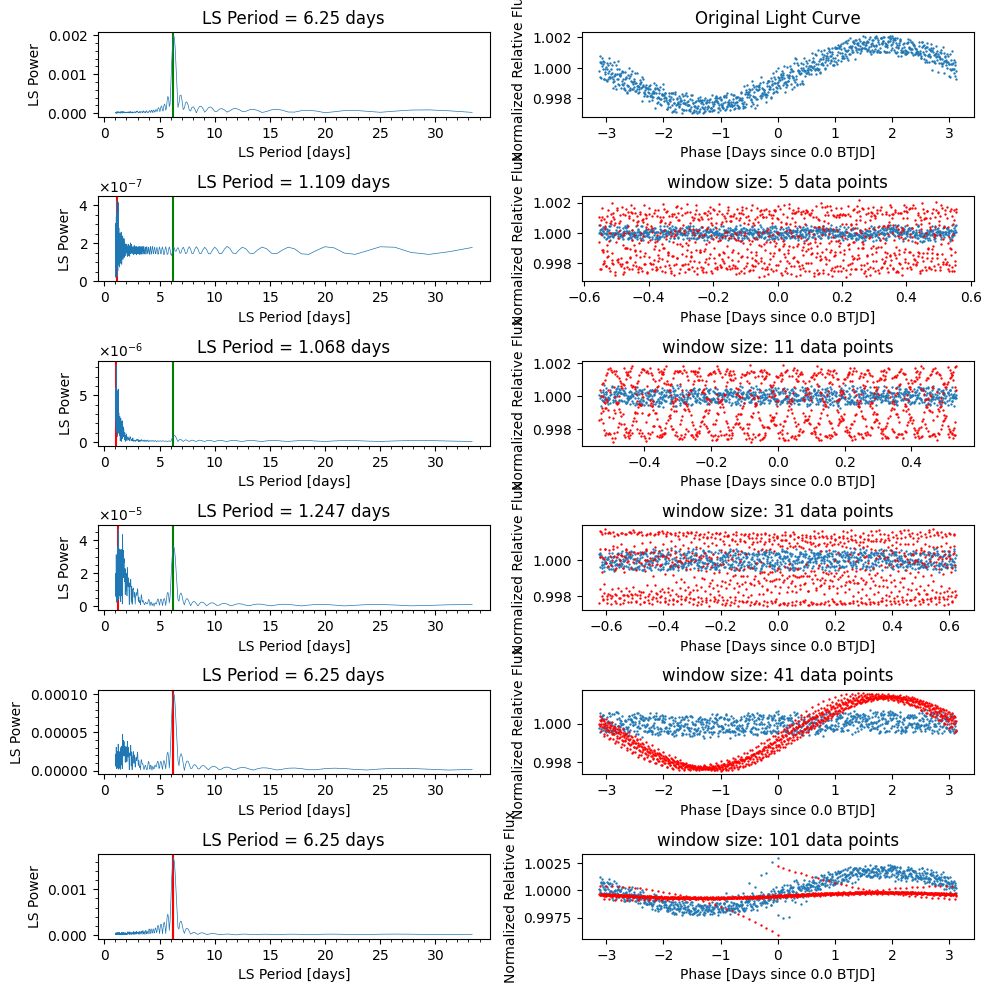

In [10]:
#smoothing

sim_newlc1,sim_trend1 = sim_lc.flatten(window_length=5,polyorder=3,return_trend=True)
sim_newlc2,sim_trend2 = sim_lc.flatten(window_length=11,polyorder=3,return_trend=True)
sim_newlc3,sim_trend3 = sim_lc.flatten(window_length=31,polyorder=3,return_trend=True)
sim_newlc4,sim_trend4 = sim_lc.flatten(window_length=41,polyorder=3,return_trend=True)
sim_newlc5,sim_trend5 = sim_lc.flatten(window_length=101,polyorder=3,return_trend=True)




# now do lomb-scargle search

sim_LS0 = sim_lc.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)
sim_LS1 = sim_newlc1.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)
sim_LS2 = sim_newlc2.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)
sim_LS3 = sim_newlc3.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)
sim_LS4 = sim_newlc4.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)
sim_LS5 = sim_newlc5.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)

# most-likely rotation period from lomb-scargle periodogram
sim_LS_period0=sim_LS0.period_at_max_power.value
sim_LS_period1=sim_LS1.period_at_max_power.value
sim_LS_period2=sim_LS2.period_at_max_power.value
sim_LS_period3=sim_LS3.period_at_max_power.value
sim_LS_period4=sim_LS4.period_at_max_power.value
sim_LS_period5=sim_LS5.period_at_max_power.value

# let's plot up the results!
import numpy as np


fig=plt.figure(figsize=(10,10))
rows=6
columns=2
ax0 = fig.add_subplot(rows, columns, 1)
ax0b = fig.add_subplot(rows, columns, 2)
ax1 = fig.add_subplot(rows, columns, 3)
ax1b = fig.add_subplot(rows, columns, 4)
ax2 = fig.add_subplot(rows, columns, 5)
ax2b = fig.add_subplot(rows, columns, 6)
ax3 = fig.add_subplot(rows, columns, 7)
ax3b = fig.add_subplot(rows, columns, 8)
ax4 = fig.add_subplot(rows, columns, 9)
ax4b = fig.add_subplot(rows, columns, 10)
ax5 = fig.add_subplot(rows, columns, 11)
ax5b = fig.add_subplot(rows, columns, 12)

sim_LS0.plot(ax=ax0)
ax0.axvline(x=sim_LS_period0,color='green',zorder=-10)
ax0.set_title('LS Period = '+str(np.round(sim_LS_period0,3))+' days')
ax0.set_xlabel('LS Period [days]')
ax0.set_ylabel('LS Power')
sim_lc.fold(period=sim_LS_period0,epoch_time=np.min(sim_lc.time.value)).scatter(s=2,ax=ax0b)
ax0b.set_xlabel('Phase [Days since '+str(np.round(np.min(sim_lc.time.value)))+' BTJD]')
ax0b.set_ylabel('Normalized Relative Flux')
ax0b.set_title('Original Light Curve')

sim_LS1.plot(ax=ax1)
ax1.axvline(x=sim_LS_period0,color='green',zorder=-10)
ax1.axvline(x=sim_LS_period1,color='red',zorder=-10)
ax1.set_title('LS Period = '+str(np.round(sim_LS_period1,3))+' days')
ax1.set_xlabel('LS Period [days]')
ax1.set_ylabel('LS Power')
sim_newlc1.fold(period=sim_LS_period1,epoch_time=np.min(sim_newlc1.time.value)).scatter(s=2,ax=ax1b)
sim_trend1.fold(period=sim_LS_period1,epoch_time=np.min(sim_newlc1.time.value)).scatter(s=2,ax=ax1b,color='red')
ax1b.set_xlabel('Phase [Days since '+str(np.round(np.min(sim_newlc1.time.value)))+' BTJD]')
ax1b.set_ylabel('Normalized Relative Flux')
ax1b.set_title('window size: '+str(5)+' data points')

sim_LS2.plot(ax=ax2)
ax2.axvline(x=sim_LS_period0,color='green',zorder=-10)
ax2.axvline(x=sim_LS_period2,color='red',zorder=-10)
ax2.set_title('LS Period = '+str(np.round(sim_LS_period2,3))+' days')
ax2.set_xlabel('LS Period [days]')
ax2.set_ylabel('LS Power')
sim_newlc2.fold(period=sim_LS_period2,epoch_time=np.min(sim_newlc2.time.value)).scatter(s=2,ax=ax2b)
sim_trend2.fold(period=sim_LS_period2,epoch_time=np.min(sim_newlc2.time.value)).scatter(s=2,ax=ax2b,color='red')
ax2b.set_xlabel('Phase [Days since '+str(np.round(np.min(sim_newlc2.time.value)))+' BTJD]')
ax2b.set_ylabel('Normalized Relative Flux')
ax2b.set_title('window size: '+str(11)+' data points')

sim_LS3.plot(ax=ax3)
ax3.axvline(x=sim_LS_period0,color='green',zorder=-10)
ax3.axvline(x=sim_LS_period3,color='red',zorder=-10)
ax3.set_title('LS Period = '+str(np.round(sim_LS_period3,3))+' days')
ax3.set_xlabel('LS Period [days]')
ax3.set_ylabel('LS Power')
sim_newlc3.fold(period=sim_LS_period3,epoch_time=np.min(sim_newlc3.time.value)).scatter(s=2,ax=ax3b)
sim_trend3.fold(period=sim_LS_period3,epoch_time=np.min(sim_newlc3.time.value)).scatter(s=2,ax=ax3b,color='red')
ax3b.set_xlabel('Phase [Days since '+str(np.round(np.min(sim_newlc3.time.value)))+' BTJD]')
ax3b.set_ylabel('Normalized Relative Flux')
ax3b.set_title('window size: '+str(31)+' data points')

sim_LS4.plot(ax=ax4)
ax4.axvline(x=sim_LS_period0,color='green',zorder=-10)
ax4.axvline(x=sim_LS_period4,color='red',zorder=-10)
ax4.set_title('LS Period = '+str(np.round(sim_LS_period4,3))+' days')
ax4.set_xlabel('LS Period [days]')
ax4.set_ylabel('LS Power')
sim_newlc4.fold(period=sim_LS_period4,epoch_time=np.min(sim_newlc4.time.value)).scatter(s=2,ax=ax4b)
sim_trend4.fold(period=sim_LS_period4,epoch_time=np.min(sim_newlc4.time.value)).scatter(s=2,ax=ax4b,color='red')
ax4b.set_xlabel('Phase [Days since '+str(np.round(np.min(sim_newlc4.time.value)))+' BTJD]')
ax4b.set_ylabel('Normalized Relative Flux')
ax4b.set_title('window size: '+str(41)+' data points')

sim_LS5.plot(ax=ax5)
ax5.axvline(x=sim_LS_period0,color='green',zorder=-10)
ax5.axvline(x=sim_LS_period5,color='red',zorder=-10)
ax5.set_title('LS Period = '+str(np.round(sim_LS_period5,3))+' days')
ax5.set_xlabel('LS Period [days]')
ax5.set_ylabel('LS Power')
sim_newlc5.fold(period=sim_LS_period5,epoch_time=np.min(sim_newlc5.time.value)).scatter(s=2,ax=ax5b)
sim_trend5.fold(period=sim_LS_period5,epoch_time=np.min(sim_newlc5.time.value)).scatter(s=2,ax=ax5b,color='red')
ax5b.set_xlabel('Phase [Days since '+str(np.round(np.min(sim_newlc5.time.value)))+' BTJD]')
ax5b.set_ylabel('Normalized Relative Flux')
ax5b.set_title('window size: '+str(101)+' data points')

fig.tight_layout(pad=1)
plt.show()

# Now that we can see that there is a relationship between choosing the right window size for a given filter and removing a signal, let's see how this same filter affects the transit signal of Wasp-18b:

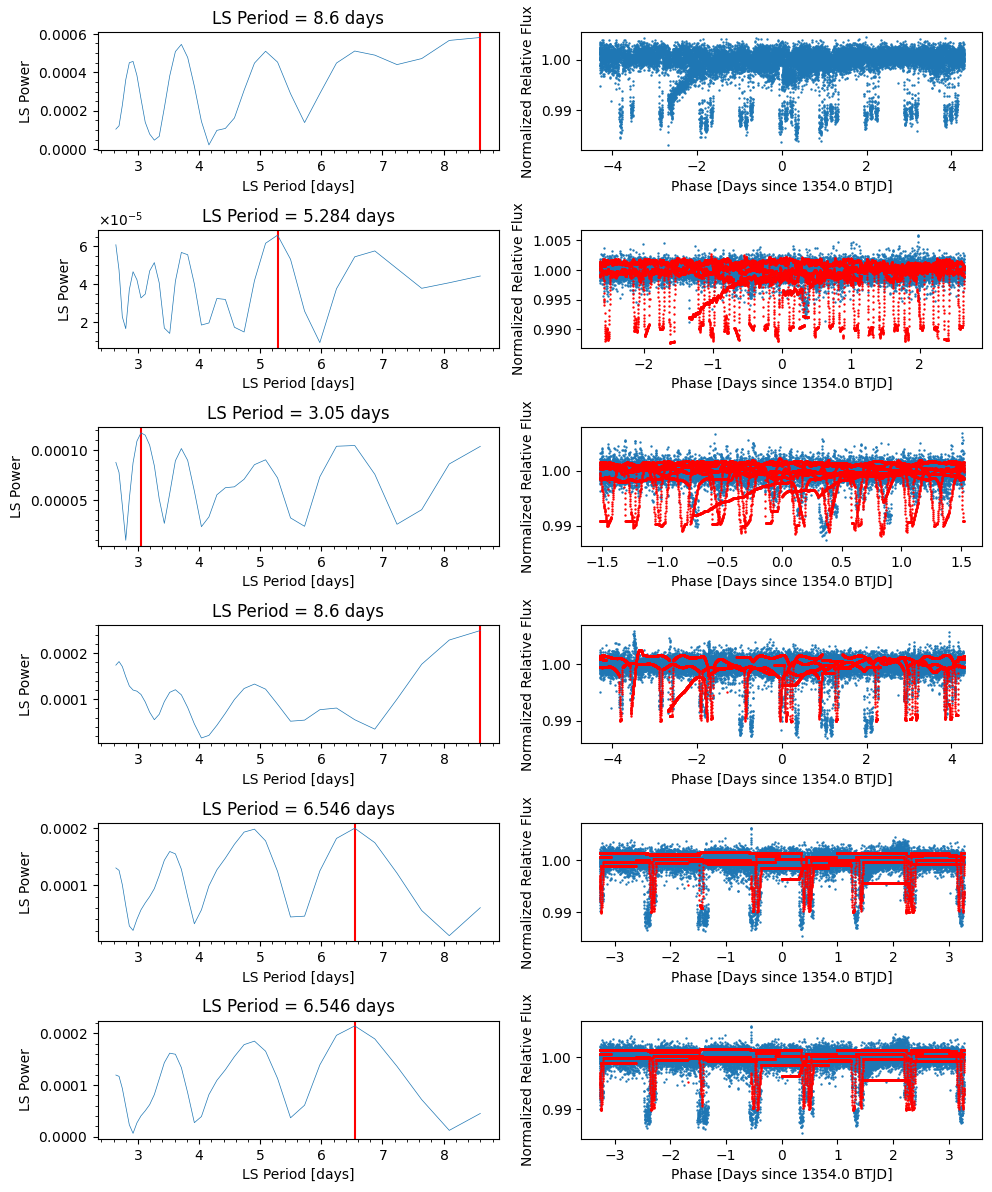

In [11]:
# max_period = (np.max(lc.time.value) - np.min(lc.time.value))/3
# The actual rotation period of WASP-18 is about 5.6 days
min_period = 5.6-3
max_period = 5.6+3

LS0 = lc.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)
LS1 = newlc1.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)
LS2 = newlc2.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)
LS3 = newlc3.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)
LS4 = newlc4.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)
LS5 = newlc5.to_periodogram(method='lombscargle',minimum_period=min_period,maximum_period=max_period)

# most-likely rotation period from lomb-scargle periodogram
LS_period0=LS0.period_at_max_power.value
LS_period1=LS1.period_at_max_power.value
LS_period2=LS2.period_at_max_power.value
LS_period3=LS3.period_at_max_power.value
LS_period4=LS4.period_at_max_power.value
LS_period5=LS5.period_at_max_power.value

# let's plot up the results!
import numpy as np


fig=plt.figure(figsize=(10,12))
rows=6
columns=2
ax0 = fig.add_subplot(rows, columns, 1)
ax0b = fig.add_subplot(rows, columns, 2)
ax1 = fig.add_subplot(rows, columns, 3)
ax1b = fig.add_subplot(rows, columns, 4)
ax2 = fig.add_subplot(rows, columns, 5)
ax2b = fig.add_subplot(rows, columns, 6)
ax3 = fig.add_subplot(rows, columns, 7)
ax3b = fig.add_subplot(rows, columns, 8)
ax4 = fig.add_subplot(rows, columns, 9)
ax4b = fig.add_subplot(rows, columns, 10)
ax5 = fig.add_subplot(rows, columns, 11)
ax5b = fig.add_subplot(rows, columns, 12)

LS0.plot(ax=ax0)
ax0.axvline(x=LS_period0,color='red',zorder=-10)
ax0.set_title('LS Period = '+str(np.round(LS_period0,3))+' days')
ax0.set_xlabel('LS Period [days]')
ax0.set_ylabel('LS Power')
lc.fold(period=LS_period0,epoch_time=np.min(lc.time.value)).scatter(s=2,ax=ax0b)
ax0b.set_xlabel('Phase [Days since '+str(np.round(np.min(lc.time.value)))+' BTJD]')
ax0b.set_ylabel('Normalized Relative Flux')

LS1.plot(ax=ax1)
ax1.axvline(x=LS_period1,color='red',zorder=-10)
ax1.set_title('LS Period = '+str(np.round(LS_period1,3))+' days')
ax1.set_xlabel('LS Period [days]')
ax1.set_ylabel('LS Power')
newlc1.fold(period=LS_period1,epoch_time=np.min(newlc1.time.value)).scatter(s=2,ax=ax1b)
trend1.fold(period=LS_period1,epoch_time=np.min(newlc1.time.value)).scatter(s=2,ax=ax1b,color='red')
ax1b.set_xlabel('Phase [Days since '+str(np.round(np.min(newlc1.time.value)))+' BTJD]')
ax1b.set_ylabel('Normalized Relative Flux')

LS2.plot(ax=ax2)
ax2.axvline(x=LS_period2,color='red',zorder=-10)
ax2.set_title('LS Period = '+str(np.round(LS_period2,3))+' days')
ax2.set_xlabel('LS Period [days]')
ax2.set_ylabel('LS Power')
newlc2.fold(period=LS_period2,epoch_time=np.min(newlc2.time.value)).scatter(s=2,ax=ax2b)
trend2.fold(period=LS_period2,epoch_time=np.min(newlc2.time.value)).scatter(s=2,ax=ax2b,color='red')
ax2b.set_xlabel('Phase [Days since '+str(np.round(np.min(newlc2.time.value)))+' BTJD]')
ax2b.set_ylabel('Normalized Relative Flux')

LS3.plot(ax=ax3)
ax3.axvline(x=LS_period3,color='red',zorder=-10)
ax3.set_title('LS Period = '+str(np.round(LS_period3,3))+' days')
ax3.set_xlabel('LS Period [days]')
ax3.set_ylabel('LS Power')
newlc3.fold(period=LS_period3,epoch_time=np.min(newlc3.time.value)).scatter(s=2,ax=ax3b)
trend3.fold(period=LS_period3,epoch_time=np.min(newlc3.time.value)).scatter(s=2,ax=ax3b,color='red')
ax3b.set_xlabel('Phase [Days since '+str(np.round(np.min(newlc3.time.value)))+' BTJD]')
ax3b.set_ylabel('Normalized Relative Flux')

LS4.plot(ax=ax4)
ax4.axvline(x=LS_period4,color='red',zorder=-10)
ax4.set_title('LS Period = '+str(np.round(LS_period4,3))+' days')
ax4.set_xlabel('LS Period [days]')
ax4.set_ylabel('LS Power')
newlc4.fold(period=LS_period4,epoch_time=np.min(newlc4.time.value)).scatter(s=2,ax=ax4b)
trend4.fold(period=LS_period4,epoch_time=np.min(newlc4.time.value)).scatter(s=2,ax=ax4b,color='red')
ax4b.set_xlabel('Phase [Days since '+str(np.round(np.min(newlc4.time.value)))+' BTJD]')
ax4b.set_ylabel('Normalized Relative Flux')

LS5.plot(ax=ax5)
ax5.axvline(x=LS_period5,color='red',zorder=-10)
ax5.set_title('LS Period = '+str(np.round(LS_period5,3))+' days')
ax5.set_xlabel('LS Period [days]')
ax5.set_ylabel('LS Power')
newlc5.fold(period=LS_period5,epoch_time=np.min(newlc5.time.value)).scatter(s=2,ax=ax5b)
trend5.fold(period=LS_period5,epoch_time=np.min(newlc5.time.value)).scatter(s=2,ax=ax5b,color='red')
ax5b.set_xlabel('Phase [Days since '+str(np.round(np.min(newlc5.time.value)))+' BTJD]')
ax5b.set_ylabel('Normalized Relative Flux')

fig.tight_layout(pad=1)
plt.show()

# The actual rotation period of WASP-18 is about 5.6 days.

# With this filter (Savitsky-Golay), it looks like the large jupiter-sized transits are making it difficult to measure the rotation signal.

# But how does this filtering of the photometry affect the transits?

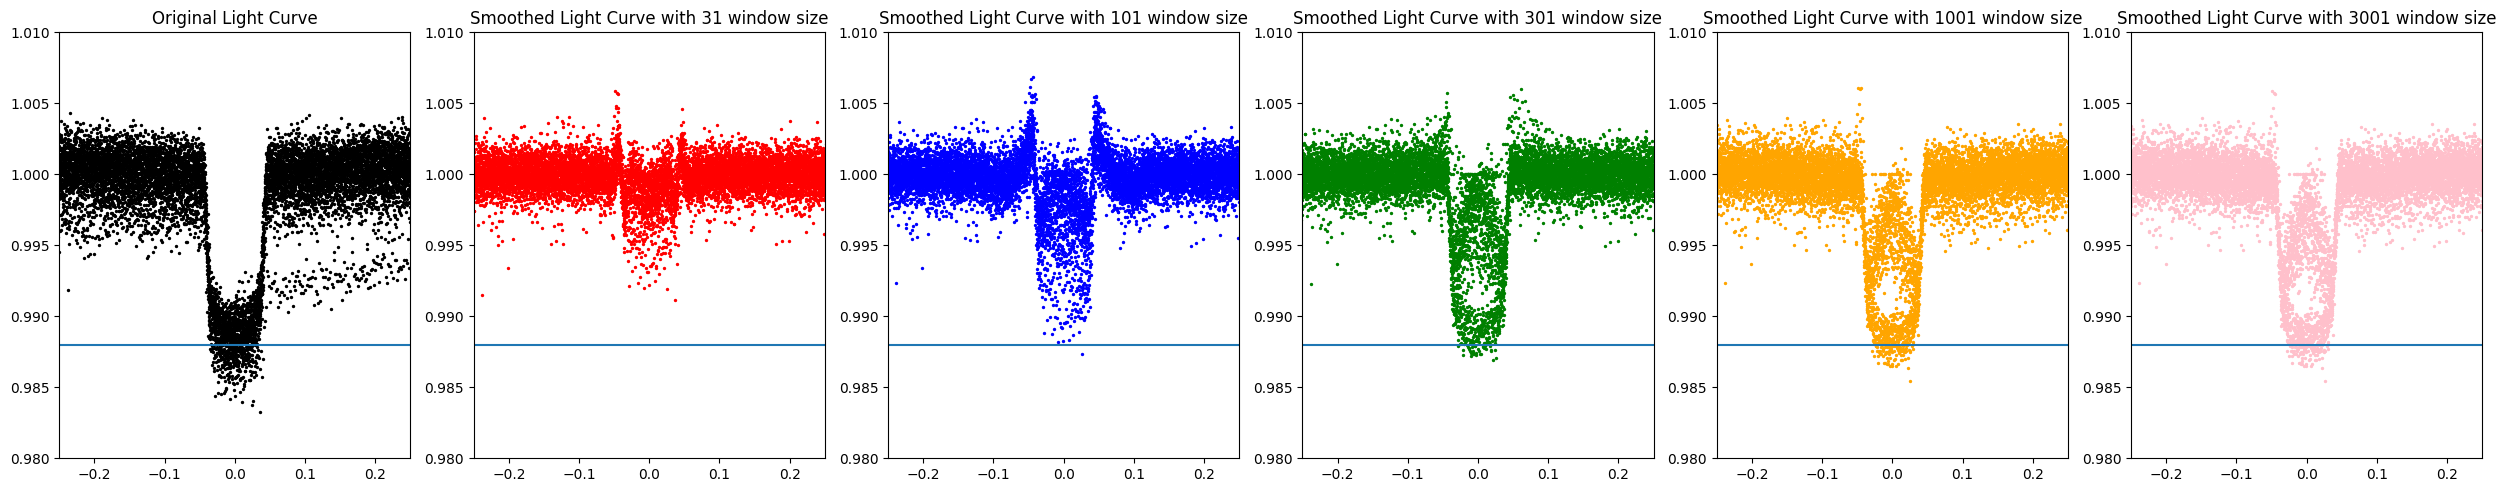

In [12]:
from lightcurve_practice_code import phasefold_version2

# let's use WASP-18b's published planet parameters
T0 = 2458375.169883 - 2457000 #converting from julian days to TESS julian days
P = 0.9414526
Dur=6/24

pf0,ff0,fe0 = phasefold_version2(lc.time.value,lc.flux.value,lc.flux_err.value,T0,P)
pf1,ff1,fe1 = phasefold_version2(newlc1.time.value,newlc1.flux.value,newlc1.flux_err.value,T0,P)
pf2,ff2,fe2 = phasefold_version2(newlc2.time.value,newlc2.flux.value,newlc2.flux_err.value,T0,P)
pf3,ff3,fe3 = phasefold_version2(newlc3.time.value,newlc3.flux.value,newlc3.flux_err.value,T0,P)
pf4,ff4,fe4 = phasefold_version2(newlc4.time.value,newlc4.flux.value,newlc4.flux_err.value,T0,P)
pf5,ff5,fe5 = phasefold_version2(newlc5.time.value,newlc5.flux.value,newlc5.flux_err.value,T0,P)


fig=plt.figure(figsize=(25,5))
rows=1
columns=6
ax0 = fig.add_subplot(rows, columns, 1)
ax1 = fig.add_subplot(rows, columns, 2)
ax2 = fig.add_subplot(rows, columns, 3)
ax3 = fig.add_subplot(rows, columns, 4)
ax4 = fig.add_subplot(rows, columns, 5)
ax5 = fig.add_subplot(rows, columns, 6)


ax0.scatter(pf0,ff0,s=2,color='black')
ax0.set_xlim(-Dur,Dur)
ax0.set_title('Original Light Curve')


ax1.scatter(pf1,ff1,s=2,color='red')
ax1.set_xlim(-Dur,Dur)
ax1.set_title('Smoothed Light Curve with '+str(31)+' window size')

ax2.scatter(pf2,ff2,s=2,color='blue')
ax2.set_xlim(-Dur,Dur)
ax2.set_title('Smoothed Light Curve with '+str(101)+' window size')

ax3.scatter(pf3,ff3,s=2,color='green')
ax3.set_xlim(-Dur,Dur)
ax3.set_title('Smoothed Light Curve with '+str(301)+' window size')

ax4.scatter(pf4,ff4,s=2,color='orange')
ax4.set_xlim(-Dur,Dur)
ax4.set_title('Smoothed Light Curve with '+str(1001)+' window size')

ax5.scatter(pf5,ff5,s=2,color='pink')
ax5.set_xlim(-Dur,Dur)
ax5.set_title('Smoothed Light Curve with '+str(3001)+' window size')

ax0.set_ylim(0.98,1.01)
ax1.set_ylim(0.98,1.01)
ax2.set_ylim(0.98,1.01)
ax3.set_ylim(0.98,1.01)
ax4.set_ylim(0.98,1.01)
ax5.set_ylim(0.98,1.01)


ax0.axhline(y=0.988)
ax1.axhline(y=0.988)
ax2.axhline(y=0.988)
ax3.axhline(y=0.988)
ax4.axhline(y=0.988)
ax5.axhline(y=0.988)

fig.tight_layout(pad=1)
plt.show()


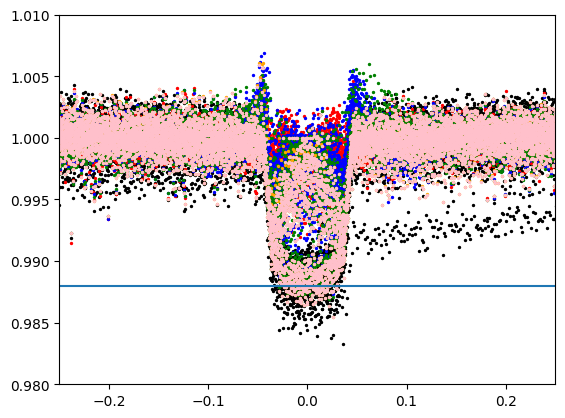

In [13]:

#stack them all on top of each other
plt.scatter(pf0,ff0,s=2,color='black')
plt.scatter(pf1,ff1,s=2,color='red')
plt.scatter(pf2,ff2,s=2,color='blue')
plt.scatter(pf3,ff3,s=2,color='green')
plt.scatter(pf4,ff4,s=2,color='orange')
plt.scatter(pf5,ff5,s=2,color='pink')

plt.xlim(-Dur,Dur)
plt.ylim(0.98,1.01)
plt.axhline(y=0.988)
fig.tight_layout(pad=1)
plt.show()

# Note, that only the black points have a characteristic "--___--" shape. The other colors have some combination of points above and below a normalized flux value of 0.985 during the transit event, which indicates that the filtering is distorting some or all of the transits. 

# With that result, we then need to consider another type of filter that won't distort the transits (or distort them much).

## Hippke et al. 2019 explored different kinds of filters and how they affected transit shapes and detectability and came up with a tool called Wotan! The documentation can be found here:
## https://wotan.readthedocs.io/en/latest/

# Let's install from a new terminal with the command:
```
pip install wotan
```



# How to use Wotan? Let's make a function!

In [14]:
def catalog_info(TIC_ID):
    """Takes TIC_ID, returns stellar information from online catalog using Vizier.
    Input Parameters
    ----------
    TIC_ID : int
        TESS Input Catalog ID number to search for and analyze.
        
    Returns
    -------
        A list of select stellar parameters.
        * (a,b): quadratic limb darkening coefficients cross-matched from 
        limb darkening Claret et al. (2012) tables based on Effective Temperature
        and Surface Gravity of target star (according to the TIC).
        * mass: Stellar Mass (from the TIC) in units of solar masses.
        * mass_min, mass_max: Uncertainty of Stellar Mass (from the TIC) in units of solar masses.
        * radius: Stellar Radius (from the TIC) in units of solar radii.
        * radius_min, radius_max: Uncertainty of Stellar Radius (from the TIC) in units of solar radii.
          
    """
    import requests
    import numpy
    from os import path
    import time as clock
    try:
        from astroquery.mast import Catalogs
    except:
        raise ImportError("Package astroquery required but failed to import")
    #
    #
    #
    result = Catalogs.query_criteria(catalog="Tic", ID=TIC_ID).as_array()
    Teff = float(result['Teff'].data)
    logg = float(result['logg'].data)
    radius = float(result['rad'].data)
    radius_max = float(result['e_rad'].data)
    radius_min = float(result['e_rad'].data)
    mass = float(result['mass'].data)
    mass_max = float(result['e_mass'].data)
    mass_min = float(result['e_mass'].data)
    
    return (mass, mass_min, mass_max, radius, radius_min, radius_max)

def SMA_AU_from_Period_to_stellar(Period,R_star,M_star):
    """
    This function will calculate the Semi-Major Axis (SMA)
    using Kepler's third law.
    
    Input Parameters
    ----------
    Period : float
        Orbital period in days
    R_star : float
        Stellar Radius in solar radii
    M_star : float
        Stellar Mass in solar masses
    Returns
    -------
        * SMA
            Semi-Major Axis in solar units
        * SMA_cm
            Semi-Major Axis in units of centimeters        
    """
    #assumes circular orbit
    #using Kepler's third law, calculate SMA
    #solar units
    import astropy.units as u
    from astropy import constants as const
    RS = u.R_sun.to(u.cm) # in cm
    MS = u.M_sun.to(u.g) # in grams
    #
    G = const.G.cgs.value #cm^3 per g per s^2
    #
    R = R_star*RS
    M = M_star*MS
    P=Period*60.0*24.0*60.0 #in seconds
    #
    #SMA
    SMA_cm = ((G*M*(P**2))/(4*(np.pi**2)))**(1/3)
    #
    #note R_star is already in solar units so we need to convert to cm using
    # solar radius as a constant
    Stellar_Radius = R #now in cm
    #
    SMA = SMA_cm / Stellar_Radius #now unitless (cm / cm)
    return SMA, SMA_cm

def Tdur(Period, R_star,M_star, R_planet_RE):
    """
    This function will calculate the transit duration
    time based on Kepler's third law. 
    Input Parameters
    ----------
    Period : float
        Orbital period in days
    R_star : float
        Stellar Radius in Solar radii
    M_star : float
        Stellar Mass in Solar masses
    R_planet_RE: float
        Planet radius in Earth Radii

    Returns
    -------
        * Tdur : float
            Estimated transit duration time in units of days
    """
    from astropy import units as u

    RE = u.R_earth.to(u.cm) # in cm
    RS = u.R_sun.to(u.cm) # in cm
    A = Period/np.pi #in days
    #
    SMA_cm = SMA_AU_from_Period_to_stellar(Period,R_star,M_star)[1]
    #
    B =(R_star*RS +R_planet_RE*RE)/ SMA_cm # unitless (cm/cm)
    #
    T_dur = A*np.arcsin(B) #in days
    return T_dur    

def smoothing_function(ID,input_LC,window_size_in_days=None,verbose=True,filter_type='biweight'):
    """   
    This function will smooth the input light curve. If no window size is
    provided, a window size corresponding to 3 times the transit duration
    of an Earth-sized planet eclipsing this target star will be used.
    Input Parameters
    ----------
    ID : int
        TESS Input Catalog identification number
    input_LC : pandas dataframe
        Input NEMESIS light curve to be smoothed
    window_size_in_days : float or None
        Desired smoothing window in units of days. Default is set to None.
    verbose : boolean
        This flag is used to print the window size used for smoothing.
    Returns
     -------
    * newlc : Lightkurve LightCurve object
        This Detrended Light Curve contains the follow column names:
        * time
        * flux #this is detrended flux
        * flux_err #this is detrended flux error
    * trend : Lightkurve LightCurve object
        This trend Light Curve contains the follow column names:
        * time
        * flux #this is smoothed lightcurve trend line
        * flux_err #this is detrended flux error (same as input_LC.flux_err)
    """
    from wotan import flatten
    import numpy as np
    import lightkurve as lk
    #
    #
    #read in LC data
    time = input_LC.time.value
    flux_raw = input_LC.flux.value
    flux_error = input_LC.flux_err.value
    #
    if window_size_in_days==None:
        LCDur=(np.nanmax(time) - np.nanmin(time))
        maxP = LCDur/2 #longest period for 2 transits in a light curve (~14 days for TESS single sector LCs)
        R_planet_RE = 1
        M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)
        window_size_in_days = 5*Tdur(maxP, R_star,M_star, R_planet_RE)
    if verbose==True:
        print('window size (days): ',window_size_in_days)
    flatten_lc, trend_lc = flatten(time, flux_raw, window_length=window_size_in_days, \
                                   return_trend=True, method=filter_type,robust=True)
    T=time
    F=flatten_lc
    FE=flux_error
    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]
    F_raw = flux_raw[nanmask]
    trend_lc=trend_lc[nanmask]
    newlc = lk.LightCurve(time=T,flux=F,flux_err=FE)
    trend = lk.LightCurve(time=time[nanmask],flux=trend_lc,flux_err=flux_error[nanmask])
    return newlc, trend




In [15]:
newlc0,trend0 = smoothing_function(ID=ID,input_LC=lc,
                                   window_size_in_days=None,verbose=True,filter_type='biweight')

newlc1,trend1 = smoothing_function(ID=ID,input_LC=lc,
                                   window_size_in_days=1,verbose=True,filter_type='biweight')

newlc2,trend2 = smoothing_function(ID=ID,input_LC=lc,
                                   window_size_in_days=12/24,verbose=True,filter_type='biweight')

newlc3,trend3 = smoothing_function(ID=ID,input_LC=lc,
                                   window_size_in_days=6/24,verbose=True,filter_type='biweight')

newlc4,trend4 = smoothing_function(ID=ID,input_LC=lc,
                                   window_size_in_days=3/24,verbose=True,filter_type='biweight')

newlc5,trend5 = smoothing_function(ID=ID,input_LC=lc,
                                   window_size_in_days=10/60/24,verbose=True,filter_type='biweight')

newlc6,trend6 = smoothing_function(ID=ID,input_LC=lc,
                                   window_size_in_days=2,verbose=True,filter_type='biweight')

window size (days):  1.1551602860349437
window size (days):  1
window size (days):  0.5
window size (days):  0.25
window size (days):  0.125
window size (days):  0.006944444444444444
window size (days):  2


# Let's look at the phasefolded light curves of the transits again

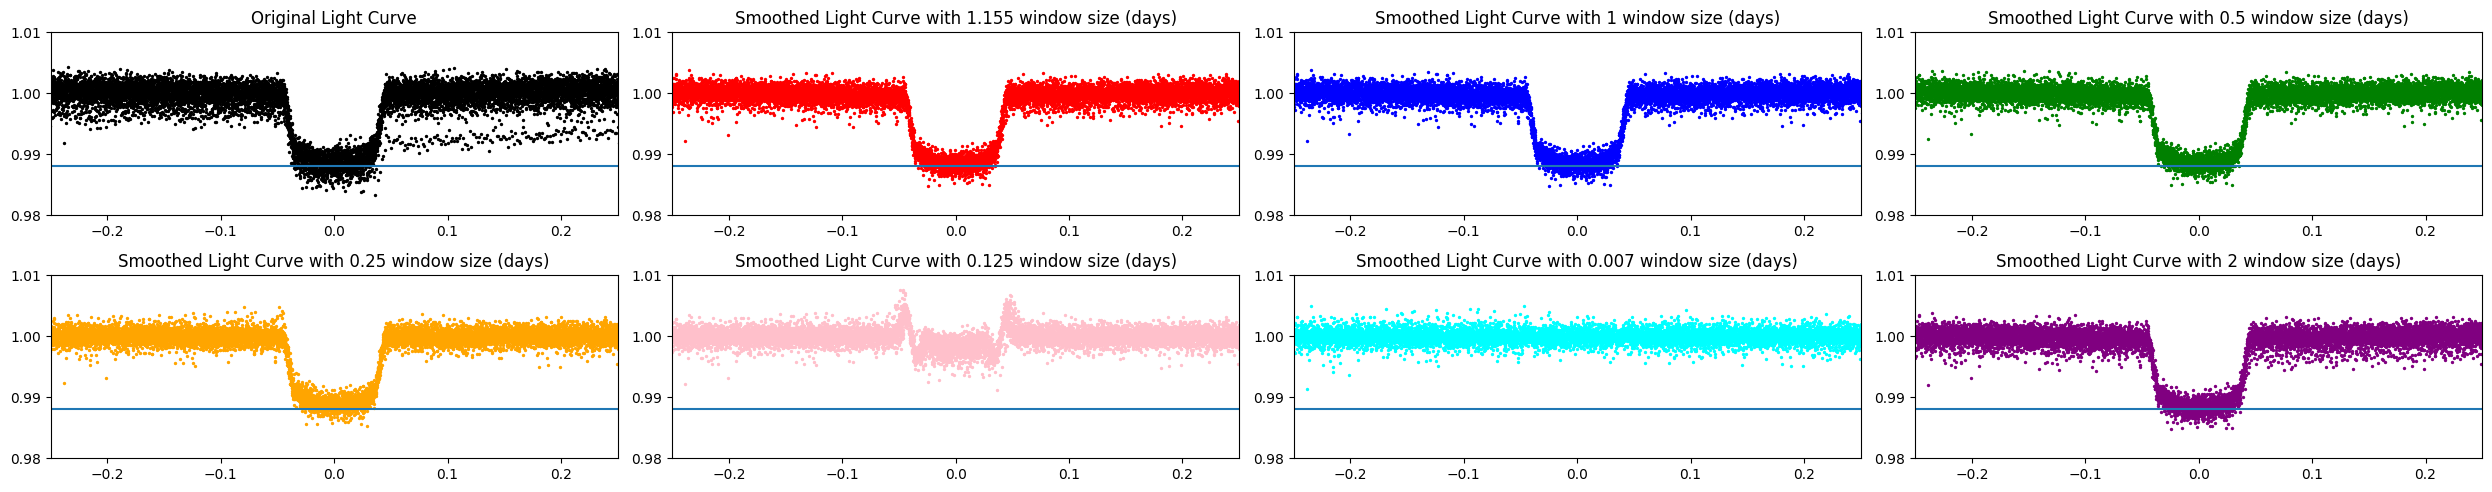

In [16]:
pf0,ff0,fe0 = phasefold_version2(lc.time.value,lc.flux.value,lc.flux_err.value,T0,P)
pf1,ff1,fe1 = phasefold_version2(newlc0.time.value,newlc0.flux.value,newlc0.flux_err.value,T0,P)
pf2,ff2,fe2 = phasefold_version2(newlc1.time.value,newlc1.flux.value,newlc1.flux_err.value,T0,P)
pf3,ff3,fe3 = phasefold_version2(newlc2.time.value,newlc2.flux.value,newlc2.flux_err.value,T0,P)
pf4,ff4,fe4 = phasefold_version2(newlc3.time.value,newlc3.flux.value,newlc3.flux_err.value,T0,P)
pf5,ff5,fe5 = phasefold_version2(newlc4.time.value,newlc4.flux.value,newlc4.flux_err.value,T0,P)
pf6,ff6,fe6 = phasefold_version2(newlc5.time.value,newlc5.flux.value,newlc5.flux_err.value,T0,P)
pf7,ff7,fe7 = phasefold_version2(newlc6.time.value,newlc6.flux.value,newlc6.flux_err.value,T0,P)



fig=plt.figure(figsize=(25,5))
rows=2
columns=4
ax0 = fig.add_subplot(rows, columns, 1)
ax1 = fig.add_subplot(rows, columns, 2)
ax2 = fig.add_subplot(rows, columns, 3)
ax3 = fig.add_subplot(rows, columns, 4)
ax4 = fig.add_subplot(rows, columns, 5)
ax5 = fig.add_subplot(rows, columns, 6)
ax6 = fig.add_subplot(rows, columns, 7)
ax7 = fig.add_subplot(rows, columns, 8)


ax0.scatter(pf0,ff0,s=2,color='black')
ax0.set_xlim(-Dur,Dur)
ax0.set_title('Original Light Curve')


ax1.scatter(pf1,ff1,s=2,color='red')
ax1.set_xlim(-Dur,Dur)
ax1.set_title('Smoothed Light Curve with '+str(1.155)+' window size (days)')

ax2.scatter(pf2,ff2,s=2,color='blue')
ax2.set_xlim(-Dur,Dur)
ax2.set_title('Smoothed Light Curve with '+str(1)+' window size (days)')

ax3.scatter(pf3,ff3,s=2,color='green')
ax3.set_xlim(-Dur,Dur)
ax3.set_title('Smoothed Light Curve with '+str(0.5)+' window size (days)')

ax4.scatter(pf4,ff4,s=2,color='orange')
ax4.set_xlim(-Dur,Dur)
ax4.set_title('Smoothed Light Curve with '+str(0.25)+' window size (days)')

ax5.scatter(pf5,ff5,s=2,color='pink')
ax5.set_xlim(-Dur,Dur)
ax5.set_title('Smoothed Light Curve with '+str(0.125)+' window size (days)')

ax6.scatter(pf6,ff6,s=2,color='cyan')
ax6.set_xlim(-Dur,Dur)
ax6.set_title('Smoothed Light Curve with '+str(np.round(10/60/24,3))+' window size (days)')

ax7.scatter(pf7,ff7,s=2,color='purple')
ax7.set_xlim(-Dur,Dur)
ax7.set_title('Smoothed Light Curve with '+str(2)+' window size (days)')

ax0.set_ylim(0.98,1.01)
ax1.set_ylim(0.98,1.01)
ax2.set_ylim(0.98,1.01)
ax3.set_ylim(0.98,1.01)
ax4.set_ylim(0.98,1.01)
ax5.set_ylim(0.98,1.01)
ax6.set_ylim(0.98,1.01)
ax7.set_ylim(0.98,1.01)


ax0.axhline(y=0.988)
ax1.axhline(y=0.988)
ax2.axhline(y=0.988)
ax3.axhline(y=0.988)
ax4.axhline(y=0.988)
ax5.axhline(y=0.988)
ax6.axhline(y=0.988)
ax7.axhline(y=0.988)

fig.tight_layout(pad=1)
plt.show()


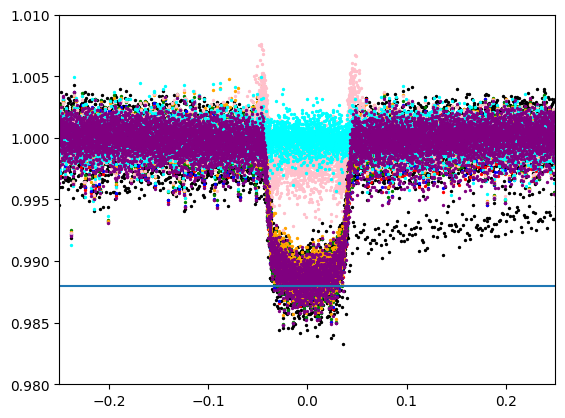

In [17]:
# stack them all together again

plt.scatter(pf0,ff0,s=2,color='black')
plt.scatter(pf1,ff1,s=2,color='red')
plt.scatter(pf2,ff2,s=2,color='blue')
plt.scatter(pf3,ff3,s=2,color='green')
plt.scatter(pf4,ff4,s=2,color='orange')
plt.scatter(pf5,ff5,s=2,color='pink')
plt.scatter(pf6,ff6,s=2,color='cyan')
plt.scatter(pf7,ff7,s=2,color='purple')
plt.xlim(-Dur,Dur)
plt.ylim(0.98,1.01)

plt.axhline(y=0.988)


fig.tight_layout(pad=1)
plt.show()


# It looks like with this new "biweight" filter, most of the window-sizes work well, (except really short windows; see pink and cyan colored data points)

# What about on our simulated light curve? How does Wotan's biweight filter affect the injected rotation signal?

window size (days):  1.7777075618572005
window size (days):  1
window size (days):  0.5
window size (days):  0.25
window size (days):  1.5
window size (days):  2.5
window size (days):  4


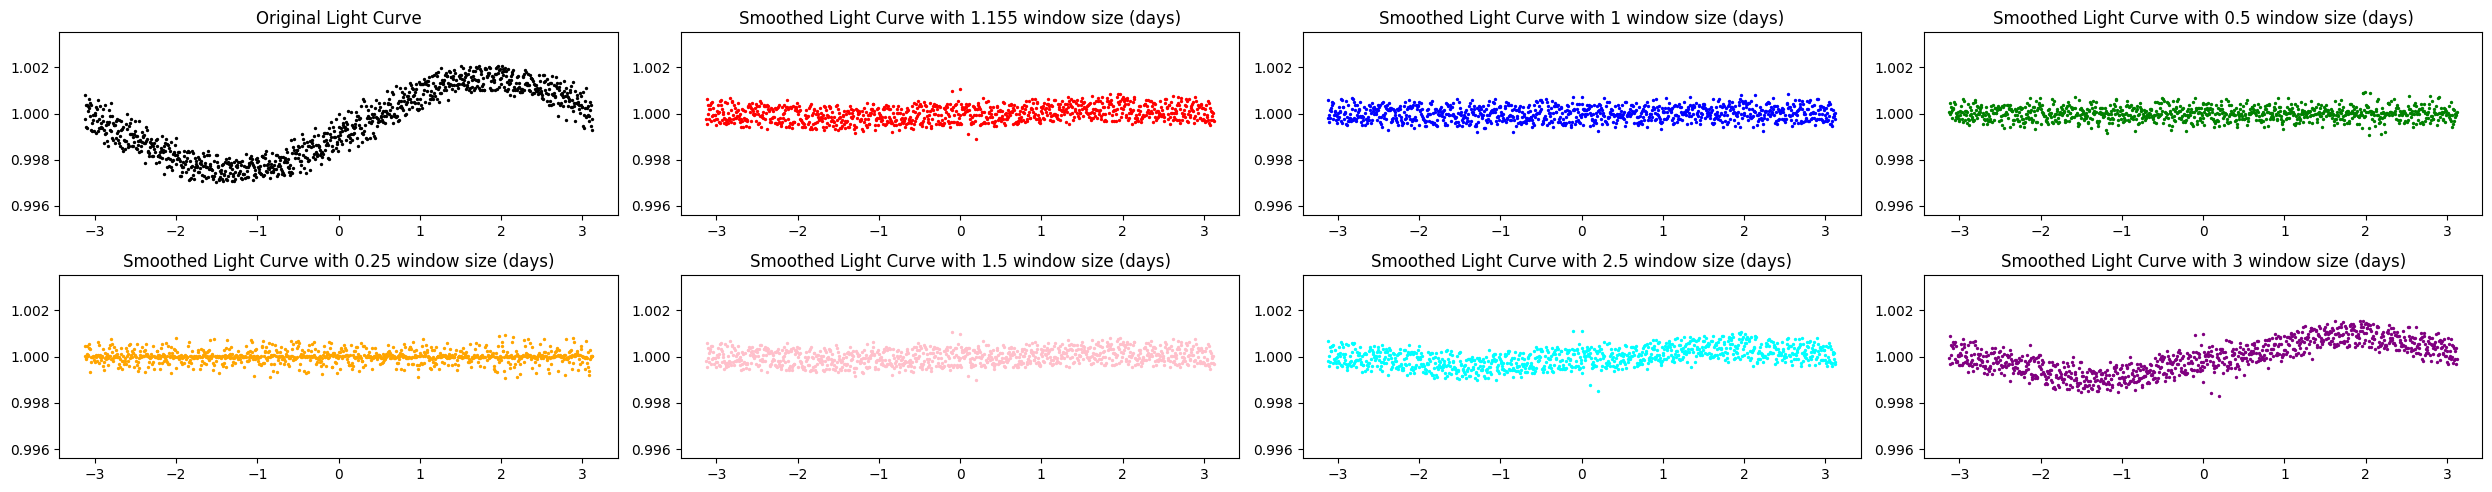

In [18]:
sim_newlc0,sim_trend0 = smoothing_function(ID=ID,input_LC=sim_lc,
                                   window_size_in_days=None,verbose=True,filter_type='biweight')

sim_newlc1,sim_trend1 = smoothing_function(ID=ID,input_LC=sim_lc,
                                   window_size_in_days=1,verbose=True,filter_type='biweight')

sim_newlc2,sim_trend2 = smoothing_function(ID=ID,input_LC=sim_lc,
                                   window_size_in_days=12/24,verbose=True,filter_type='biweight')

sim_newlc3,sim_trend3 = smoothing_function(ID=ID,input_LC=sim_lc,
                                   window_size_in_days=6/24,verbose=True,filter_type='biweight')

sim_newlc4,sim_trend4 = smoothing_function(ID=ID,input_LC=sim_lc,
                                   window_size_in_days=1.5,verbose=True,filter_type='biweight')

sim_newlc5,sim_trend5 = smoothing_function(ID=ID,input_LC=sim_lc,
                                   window_size_in_days=2.5,verbose=True,filter_type='biweight')

sim_newlc6,sim_trend6 = smoothing_function(ID=ID,input_LC=sim_lc,
                                   window_size_in_days=4,verbose=True,filter_type='biweight')

sim_T0=np.nanmin(sim_lc.time.value)
sim_P = sim_LS_period0

pf0,ff0,fe0 = phasefold_version2(sim_lc.time.value,sim_lc.flux.value,sim_lc.flux_err.value,sim_T0,sim_P)
pf1,ff1,fe1 = phasefold_version2(sim_newlc0.time.value,sim_newlc0.flux.value,sim_newlc0.flux_err.value,sim_T0,sim_P)
pf2,ff2,fe2 = phasefold_version2(sim_newlc1.time.value,sim_newlc1.flux.value,sim_newlc1.flux_err.value,sim_T0,sim_P)
pf3,ff3,fe3 = phasefold_version2(sim_newlc2.time.value,sim_newlc2.flux.value,sim_newlc2.flux_err.value,sim_T0,sim_P)
pf4,ff4,fe4 = phasefold_version2(sim_newlc3.time.value,sim_newlc3.flux.value,sim_newlc3.flux_err.value,sim_T0,sim_P)
pf5,ff5,fe5 = phasefold_version2(sim_newlc4.time.value,sim_newlc4.flux.value,sim_newlc4.flux_err.value,sim_T0,sim_P)
pf6,ff6,fe6 = phasefold_version2(sim_newlc5.time.value,sim_newlc5.flux.value,sim_newlc5.flux_err.value,sim_T0,sim_P)
pf7,ff7,fe7 = phasefold_version2(sim_newlc6.time.value,sim_newlc6.flux.value,sim_newlc6.flux_err.value,sim_T0,sim_P)



fig=plt.figure(figsize=(25,5))
rows=2
columns=4
ax0 = fig.add_subplot(rows, columns, 1)
ax1 = fig.add_subplot(rows, columns, 2)
ax2 = fig.add_subplot(rows, columns, 3)
ax3 = fig.add_subplot(rows, columns, 4)
ax4 = fig.add_subplot(rows, columns, 5)
ax5 = fig.add_subplot(rows, columns, 6)
ax6 = fig.add_subplot(rows, columns, 7)
ax7 = fig.add_subplot(rows, columns, 8)


ax0.scatter(pf0,ff0,s=2,color='black')
ax0.set_title('Original Light Curve')


ax1.scatter(pf1,ff1,s=2,color='red')
ax1.set_title('Smoothed Light Curve with '+str(1.155)+' window size (days)')

ax2.scatter(pf2,ff2,s=2,color='blue')
ax2.set_title('Smoothed Light Curve with '+str(1)+' window size (days)')

ax3.scatter(pf3,ff3,s=2,color='green')
ax3.set_title('Smoothed Light Curve with '+str(0.5)+' window size (days)')

ax4.scatter(pf4,ff4,s=2,color='orange')
ax4.set_title('Smoothed Light Curve with '+str(0.25)+' window size (days)')

ax5.scatter(pf5,ff5,s=2,color='pink')
ax5.set_title('Smoothed Light Curve with '+str(1.5)+' window size (days)')

ax6.scatter(pf6,ff6,s=2,color='cyan')
ax6.set_title('Smoothed Light Curve with '+str(np.round(2.5,3))+' window size (days)')

ax7.scatter(pf7,ff7,s=2,color='purple')
ax7.set_title('Smoothed Light Curve with '+str(3)+' window size (days)')

ymin=np.nanmin(sim_lc.flux.value)-1*np.nanstd(sim_lc.flux.value)
ymax=np.nanmax(sim_lc.flux.value)+1*np.nanstd(sim_lc.flux.value)


ax0.set_ylim(ymin,ymax)
ax1.set_ylim(ymin,ymax)
ax2.set_ylim(ymin,ymax)
ax3.set_ylim(ymin,ymax)
ax4.set_ylim(ymin,ymax)
ax5.set_ylim(ymin,ymax)
ax6.set_ylim(ymin,ymax)
ax7.set_ylim(ymin,ymax)



fig.tight_layout(pad=1)
plt.show()


# In this case, shorter windows are really good at removing rotation signal but longer windows seem to keep it

# So, if we wanted to include this new smoothing procedure, we have to turn it into a function and add it to our "extract_TESS_photometry" function see :
## https://github.com/daxfeliz/SRMP_Project_2024/blob/main/lightcurve_practice_code.py

In [19]:
import os
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

def extract_TESS_photometry(starname,author,nsigma,save_directory,mask_threshold=None):
    '''
    This function is used to extract single sector TESS light curves
    . Currently, 
    this function will only grab the first set of TESS observations
    from the 
    observation tables (search_result object).
    
    Inputs
    ------------------------------------------------------
        starname: Name of the star. Ex: 'TIC 12345678',
        'Proxima Centauri'. Object type: string, str
        author: 'Source of the TESS data. Ex: SPOC,
        TESS-SPOC, QLP'. Object type: string, str 
        nsigma: The number of standard deviations above and below 
        the median of our light curves to remove data from. type: float    
        save_directory: location on computer where figures are saved
        mask_threshold: Input value for aperture selection. 
        type: float or NoneType.
    
    Outputs
    ------------------------------------------------------
        outlier_removed_normalized_bkg_subtracted_lc: a lightkurve object containing
        extracted TESS photometry that is background subtracted, outlier removed and
        then normalized.
    '''
    #Step 0: import libraries we need
    import lightkurve as lk
    import matplotlib.pyplot as plt
    
    # Step 1: Search for TESS images (Target Pixel Files, or tpf)    
    search_result = lk.search_targetpixelfile(starname,author=author)
    
    # recall, MAST has a weird change in their observations table
    # -dataURL ---> dataURI
    # to make sure it's included, let's use a try and except technique    
    try:
        tpf = search_result[0].download(quality_bitmask='hardest',download_dir=save_directory) 
        #will download only first observation [0]
    except KeyError:
        search_result.table['dataURL']  = search_result.table['dataURI']
        tpf = search_result[0].download(quality_bitmask='hardest',download_dir=save_directory)
    
    #Step 2: Perform aperture photometry
    if mask_threshold is None:
        pixel_mask = tpf.pipeline_mask
        background_mask = ~tpf.pipeline_mask
    if mask_threshold is not None:
        pixel_mask = tpf.create_threshold_mask(threshold=mask_threshold)
        background_mask = ~tpf.create_threshold_mask(threshold=mask_threshold)

    lc = tpf.to_lightcurve(aperture_mask=pixel_mask)
    bkg = tpf.to_lightcurve(aperture_mask=background_mask)
    
    #Step 3: Perform Background Subtraction and Normalization
    bkg_subtracted_flux=lc.flux.value - bkg.flux.value
    
    #create new "LightCurve" object
    bkg_subtracted_lc = lk.LightCurve(time=lc.time.value,
                                      flux=bkg_subtracted_flux,
                                      flux_err = lc.flux_err.value)
    
    # normalize the background subtracted light curve
    normalized_bkg_subtracted_lc =  bkg_subtracted_lc.normalize()
    
    outlier_removed_normalized_bkg_subtracted_lc = normalized_bkg_subtracted_lc.remove_outliers(sigma_upper=nsigma)
    
    # Step 4: Visualize the light curve
    fig=plt.figure(figsize=(10,5))
    ax1=fig.add_subplot(221)
    ax2=fig.add_subplot(222)
    
    tpf.plot(aperture_mask=pixel_mask,mask_color='red',
             ax=ax1,show_colorbar=True)
    tpf.plot(aperture_mask=background_mask,mask_color='pink',
             ax=ax1,show_colorbar=False)
    
    
    ax2.set_title(starname+' in Sector '+str(tpf.sector))
    
    ax2.plot(normalized_bkg_subtracted_lc.time.value,
             normalized_bkg_subtracted_lc.flux.value,
           marker='.',color='red',linestyle='none')
    
    ax2.plot(outlier_removed_normalized_bkg_subtracted_lc.time.value,
             outlier_removed_normalized_bkg_subtracted_lc.flux.value,
           marker='.',color='black',linestyle='none')    
  
    ax2.set_xlabel('Time [Days]')
    ax2.set_ylabel('Normalized Relative Flux')
    fig.tight_layout(pad=1)
    plt.savefig(save_directory+starname+'_Sector_'+str(tpf.sector)+'_lightcurve.png',
                bbox_inches='tight')
    plt.show()
    
    return outlier_removed_normalized_bkg_subtracted_lc
    
    
def phasefold_version2(time,flux,flux_err,T0,Period):
    ''' 
    Version 2 is calculating the number of orbital cycles in 
    our light curve but is also shifted so that the phase value
    of 0 is at the T0 reference time.
    Input:
        time: array of timestamps
        flux: array of flux values
        flux_err: array of flux uncertainty values
        T0: float, reference time
        Period: float, orbital period
    Output:
        phase: array of phase values
        flux: array of flux values
        flux_err: array of flux uncertainty values
    '''    
    phase = (time - T0 + 0.5*Period) % Period - 0.5*Period
    ind = np.argsort(phase,axis=0)
    
    return phase[ind], flux[ind], flux_err[ind]

def fullphasefold(time,T0,period,flux,offset):
    """
    This function will phase-fold the input light curve (time, flux)
    using a Mid-transit time and orbital period.
    
    Input Parameters
    ----------
    time: array
        An array of timestamps from TESS observations.        
    TO : float
        The Mid-transit time of a periodic event.
    period : float
        An orbital period of a periodic event.
    flux : array
        An array of flux values from TESS observations.
    offset : int or float
        A value used to offset the phase by a fraction of an orbit.
        
    Returns
    -------
        * phase : array
            An array of Orbital phase of the phase-folded light curve.
        * flux : array
            An array of flux values from TESS observations of the 
            phase-folded light curve.
    """
    phase= (time - T0+ offset*period) / period - np.floor((time - T0+ offset*period) / period)
    ind=np.argsort(phase, axis=0)
    return phase[ind],flux[ind]
        
# grid functions for transit searching
# constants from transitleastsquares
#
# astrophysical constants
import astropy.units as u
from astropy import constants as const
R_sun = u.R_sun.to(u.cm) # in cm
M_sun = u.M_sun.to(u.g) # in grams
G = const.G.cgs.value #cm^3 per g per s^2
R_earth = u.R_earth.to(u.cm) # in cm
R_jup = u.R_jupiter.to(u.cm) # in cm
SECONDS_PER_DAY = u.day.to(u.second)


# For the duration grid
FRACTIONAL_TRANSIT_DURATION_MAX = 0.12
M_STAR_MIN = 0.1
M_STAR_MAX = 1.0
R_STAR_MIN = 0.13
R_STAR_MAX = 3.5
DURATION_GRID_STEP = 1.05
OVERSAMPLING_FACTOR = 5
N_TRANSITS_MIN = 3
MINIMUM_PERIOD_GRID_SIZE = 100

def T14(
    R_s, M_s, P, upper_limit=FRACTIONAL_TRANSIT_DURATION_MAX, small=False
):
    """Input:  Stellar radius and mass; planetary period
               Units: Solar radius and mass; days
       Output: Maximum planetary transit duration T_14max
               Unit: Fraction of period P"""
    import numpy
    
    pi = numpy.pi
    P = P * SECONDS_PER_DAY
    R_s = R_sun * R_s
    M_s = M_sun * M_s

    if small:  # small planet assumption
        T14max = R_s * ((4 * P) / (pi * G * M_s)) ** (1 / 3)
    else:  # planet size 2 R_jup
        T14max = (R_s + 2 * R_jup) * (
            (4 * P) / (pi * G * M_s)
        ) ** (1 / 3)

    result = T14max / P
    if result > upper_limit:
        result = upper_limit
    return result


def duration_grid(periods, shortest, log_step=DURATION_GRID_STEP):
    import numpy    
    duration_max = T14(
        R_s=R_STAR_MAX,
        M_s=M_STAR_MAX,
        P=numpy.min(periods),
        small=False  # large planet for long transit duration
    )
    duration_min = T14(
        R_s=R_STAR_MIN,
        M_s=M_STAR_MIN,
        P=numpy.max(periods),
        small=True  # small planet for short transit duration
    )

    durations = [duration_min]
    current_depth = duration_min
    while current_depth * log_step < duration_max:
        current_depth = current_depth * log_step
        durations.append(current_depth)
    durations.append(duration_max)  # Append endpoint. Not perfectly spaced.
    return durations
def find_min_trial_duration(input_LC,durations,periods):
    # this function takes the duration_grid and period_grid
    # provided by TLS' functions (which are based on stellar params)
    #
    def Special_Bin_func(time,flux,error,binsize):  #<-- doesn't allow empty bins to exist
        import math
        good = np.where(np.isfinite(time)) #finds values that are not +/- inf, NaN
        timefit = time[good]
        fluxfit = flux[good]
        errfit  = error[good]
        timemax = np.max(timefit)
        timemin = np.min(timefit)
        npoints = len(timefit)
        nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days
        bintime = np.full((nbins,), np.nan) #fills array with NaNs to be filled with values
        binflux = np.full((nbins,), np.nan)
        binerr  = np.full((nbins,), np.nan)
        for i in range(0,nbins-1):
            tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )]
            if len(tobin[0][0]) != 0:
                # inverse variance weighted means
                binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
                bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
                binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
        #
        return bintime, binflux, binerr
    #
    def calc_phase_coverage(input_LC,trial_duration,trial_period):
        t,f,e = input_LC.time.value, input_LC.flux.value, input_LC.flux_err.value
        T0 = np.nanmin(t)
        pf,ff,fe = phasefold_version2(t,f,e,T0,trial_period)
        binpf,binff,binfe = Special_Bin_func(pf,ff,e,binsize=trial_duration)
        ntotal=len(binpf)
        fin_bin = len(np.where(np.isfinite(binpf))[0])
        phase_coverage = fin_bin / ntotal
        return phase_coverage
    #
    # calculate phase coverage for input lightcurve
    phase_coverage = np.empty(np.size(durations))
    #do min P only
    for c in range(len(phase_coverage)):
        pc = calc_phase_coverage(input_LC,\
                                 trial_duration=durations[c],\
                                 trial_period=np.min(periods))
        phase_coverage[c] = pc
        
    q=0.25
    q_ind = np.where(phase_coverage==np.quantile(phase_coverage,q,interpolation='nearest'))[0][0]
    min_trial_duration = durations[q_ind]

    if min_trial_duration < (np.nanmedian(np.diff( input_LC.time.value ))/2 ):
        #print('min duration < half cadence!')
        min_trial_duration = (np.nanmedian(np.diff( input_LC.time.value )))/2

    durations=np.array(durations)
    new_durations = durations[durations>=min_trial_duration]
    new_durations = new_durations.tolist()
    
    return new_durations


def period_grid(
    R_star,
    M_star,
    time_span,
    period_min=0,
    period_max=float("inf"),
    oversampling_factor=OVERSAMPLING_FACTOR,
    n_transits_min=N_TRANSITS_MIN,
):
    """Returns array of optimal sampling periods for transit search in light curves
       Following Ofir (2014, A&A, 561, A138)"""
    import numpy
    pi = numpy.pi

    if R_star < 0.01:
        text = (
            "Warning: R_star was set to 0.01 for period_grid (was unphysical: "
            + str(R_star)
            + ")"
        )
        warnings.warn(text)
        R_star = 0.1

    if R_star > 10000:
        text = (
            "Warning: R_star was set to 10000 for period_grid (was unphysical: "
            + str(R_star)
            + ")"
        )
        warnings.warn(text)
        R_star = 10000

    if M_star < 0.01:
        text = (
            "Warning: M_star was set to 0.01 for period_grid (was unphysical: "
            + str(M_star)
            + ")"
        )
        warnings.warn(text)
        M_star = 0.01

    if M_star > 1000:
        text = (
            "Warning: M_star was set to 1000 for period_grid (was unphysical: "
            + str(M_star)
            + ")"
        )
        warnings.warn(text)
        M_star = 1000

    R_star = R_star * R_sun
    M_star = M_star * M_sun
    time_span = time_span * SECONDS_PER_DAY  # seconds

    # boundary conditions
    f_min = n_transits_min / time_span
    f_max = 1.0 / (2 * pi) * np.sqrt(G * M_star / (3 * R_star) ** 3)

    # optimal frequency sampling, Equations (5), (6), (7)
    A = (
        (2 * pi) ** (2.0 / 3)
        / pi
        * R_star
        / (G * M_star) ** (1.0 / 3)
        / (time_span * oversampling_factor)
    )
    C = f_min ** (1.0 / 3) - A / 3.0
    N_opt = (f_max ** (1.0 / 3) - f_min ** (1.0 / 3) + A / 3) * 3 / A

    X = numpy.arange(N_opt) + 1
    f_x = (A / 3 * X + C) ** 3
    P_x = 1 / f_x

    # Cut to given (optional) selection of periods
    periods = P_x / SECONDS_PER_DAY
    selected_index = numpy.where(
        numpy.logical_and(periods > period_min, periods <= period_max)
    )

    number_of_periods = numpy.size(periods[selected_index])

    if number_of_periods > 10 ** 6:
        text = (
            "period_grid generates a very large grid ("
            + str(number_of_periods)
            + "). Recommend to check physical plausibility for stellar mass, radius, and time series duration."
        )
        warnings.warn(text)

    if number_of_periods < MINIMUM_PERIOD_GRID_SIZE:
        if time_span < 5 * SECONDS_PER_DAY:
            time_span = 5 * SECONDS_PER_DAY
        warnings.warn(
            "period_grid defaults to R_star=1 and M_star=1 as given density yielded grid with too few values"
        )
        return period_grid(
            R_star=1, M_star=1, time_span=time_span / SECONDS_PER_DAY
        )
    else:
        return periods[selected_index]  # periods in [days]

def radius_from_mass(M_star):
    if M_star<=1:
        R_star = M_star**0.8
    if M_star>1:
        R_star = M_star**0.57
    return R_star
def mass_from_radius(R_star):
    if R_star<=1:
        M_star = R_star**(1/0.8)
    if R_star>1:
        M_star = R_star**(1/0.57)        
    return M_star    
    
def BLS_function(starname, input_lc,min_period,max_period,R_star,M_star,
                 oversampling_factor=9,duration_grid_step=1.05):
    '''
    This function is designed to conduct blind 
    transit searches using the BLS algorithm.
    
    Inputs:
        starname: 
            Name of the star, string
        input_lc: 
            lightkurve object of the input lightcurve, lk.LightCurve
        min_period: 
            minimum period for the blind BLS transit search, floats
        max_period: 
            maximum period for the blind BLS transit search, floats
        R_star:
            Stellar Radius of target star in Solar units, float
        M_star:
            Stellar Mass of target star in Solar units, float            
        duration_grid_step: the number of periods in our period grid, integer       
    
    Outputs:
       - planet_period: The best-fit orbital period from the 
                        BLS transit search, float
       - planet_t0: The best-fit transit time from the 
                        BLS transit search, float
       - planet_dur: The best-fit transit duration from the 
                        BLS transit search, float
       - figure: a two panel figure showing the BLS power spectrum
                 and the phase-folded light curve on the BLS result, 
                 PNG file
    '''
    
    #step 1: creating period grid for transit searches
#     period_grid = np.linspace(min_period,max_period,N_periods)
#     duration_grid=np.linspace(min_dur  ,max_dur,N_durations)
    #
    LC_time_span = (np.max(input_lc.time.value)-np.min(input_lc.time.value)) #time span of light curve
    #
    periods = period_grid(R_star=R_star, M_star=M_star, time_span=LC_time_span,\
                              period_min=min_period, period_max=max_period,
                              oversampling_factor=oversampling_factor)
    #
    durations= duration_grid(periods,shortest=None,log_step=duration_grid_step)
    durations = find_min_trial_duration(input_lc,durations,periods)
    
    #step 2: conducting the blind BLS transit search
    bls = input_lc.to_periodogram(method='bls',
                                  period=periods,
                                  duration=durations)#,
                                  #frequency_factor=frequency_factor)
    
    #step 3: plotting BLS power spectra and calculating
    #        BLS Period, T0 and Duration
    
    #plotting power spectram AKA periodogram
    fig=plt.figure(figsize=(10,5))
    ax1=fig.add_subplot(211)
    ax2=fig.add_subplot(212)
    
    bls.plot(color='black',lw=2,ax=ax1)
    ax1.set_title(starname+' BLS Power Spectrum')
   
    
    # calculating BLS Period, T0 and Duration
    planet_period = bls.period_at_max_power
    planet_t0 = bls.transit_time_at_max_power
    planet_dur = bls.duration_at_max_power
    ax1.axvline(x=planet_period.value,color='red',lw=3,alpha=0.5,zorder=-10)
    print('BLS period is ',planet_period)
    print('BLS reference time is',planet_t0)
    print('BLS duration is',planet_dur)
    print('')
    
    
    # step 4: phasefolding on BLS results
    
    phase, flux, flux_err = phasefold_version2(input_lc.time.value,input_lc.flux.value,input_lc.flux_err.value,
                                               planet_t0.value, planet_period.value)
    
    ax2.plot(phase*24,flux,'k.',markersize=3) #note phase2 x 24 makes phase in units of hours, not days like above
    ax2.set_xlabel('Orbital Phase [Hours since T0]\nzoomed in +/- 3 transit durations')
    ax2.set_ylabel('Normalized Relative Flux')
    ax2.set_xlim(-3.5*planet_dur.value*24,3.5*planet_dur.value*24)
    ax2.axvline(x=0)
    fig.tight_layout(pad=1)
    fig.savefig(starname+'_BLS_result.png',bbox_inches='tight')
    plt.show()
    
    
    return planet_period.value, planet_t0.value, planet_dur.value


def catalog_info(TIC_ID):
    """Takes TIC_ID, returns stellar information from online catalog using Vizier.
    Input Parameters
    ----------
    TIC_ID : int
        TESS Input Catalog ID number to search for and analyze.
        
    Returns
    -------
        A list of select stellar parameters.
        * (a,b): quadratic limb darkening coefficients cross-matched from 
        limb darkening Claret et al. (2012) tables based on Effective Temperature
        and Surface Gravity of target star (according to the TIC).
        * mass: Stellar Mass (from the TIC) in units of solar masses.
        * mass_min, mass_max: Uncertainty of Stellar Mass (from the TIC) in units of solar masses.
        * radius: Stellar Radius (from the TIC) in units of solar radii.
        * radius_min, radius_max: Uncertainty of Stellar Radius (from the TIC) in units of solar radii.
          
    """
    import requests
    import numpy
    from os import path
    import time as clock
    try:
        from astroquery.mast import Catalogs
    except:
        raise ImportError("Package astroquery required but failed to import")
    #
    #
    #
    result = Catalogs.query_criteria(catalog="Tic", ID=TIC_ID).as_array()
    Teff = float(result['Teff'].data)
    logg = float(result['logg'].data)
    radius = float(result['rad'].data)
    radius_max = float(result['e_rad'].data)
    radius_min = float(result['e_rad'].data)
    mass = float(result['mass'].data)
    mass_max = float(result['e_mass'].data)
    mass_min = float(result['e_mass'].data)
    
    return (mass, mass_min, mass_max, radius, radius_min, radius_max)

def SMA_AU_from_Period_to_stellar(Period,R_star,M_star):
    """
    This function will calculate the Semi-Major Axis (SMA)
    using Kepler's third law.
    
    Input Parameters
    ----------
    Period : float
        Orbital period in days
    R_star : float
        Stellar Radius in solar radii
    M_star : float
        Stellar Mass in solar masses
    Returns
    -------
        * SMA
            Semi-Major Axis in solar units
        * SMA_cm
            Semi-Major Axis in units of centimeters        
    """
    #assumes circular orbit
    #using Kepler's third law, calculate SMA
    #solar units
    import astropy.units as u
    from astropy import constants as const
    RS = u.R_sun.to(u.cm) # in cm
    MS = u.M_sun.to(u.g) # in grams
    #
    G = const.G.cgs.value #cm^3 per g per s^2
    #
    R = R_star*RS
    M = M_star*MS
    P=Period*60.0*24.0*60.0 #in seconds
    #
    #SMA
    SMA_cm = ((G*M*(P**2))/(4*(np.pi**2)))**(1/3)
    #
    #note R_star is already in solar units so we need to convert to cm using
    # solar radius as a constant
    Stellar_Radius = R #now in cm
    #
    SMA = SMA_cm / Stellar_Radius #now unitless (cm / cm)
    return SMA, SMA_cm

def Tdur(Period, R_star,M_star, R_planet_RE):
    """
    This function will calculate the transit duration
    time based on Kepler's third law. 
    Input Parameters
    ----------
    Period : float
        Orbital period in days
    R_star : float
        Stellar Radius in Solar radii
    M_star : float
        Stellar Mass in Solar masses
    R_planet_RE: float
        Planet radius in Earth Radii

    Returns
    -------
        * Tdur : float
            Estimated transit duration time in units of days
    """
    from astropy import units as u

    RE = u.R_earth.to(u.cm) # in cm
    RS = u.R_sun.to(u.cm) # in cm
    A = Period/np.pi #in days
    #
    SMA_cm = SMA_AU_from_Period_to_stellar(Period,R_star,M_star)[1]
    #
    B =(R_star*RS +R_planet_RE*RE)/ SMA_cm # unitless (cm/cm)
    #
    T_dur = A*np.arcsin(B) #in days
    return T_dur    

def smoothing_function(ID,input_LC,window_size_in_days=None,verbose=True,filter_type='biweight'):
    """   
    This function will smooth the input light curve. If no window size is
    provided, a window size corresponding to 3 times the transit duration
    of an Earth-sized planet eclipsing this target star will be used.
    Input Parameters
    ----------
    ID : int
        TESS Input Catalog identification number
    input_LC : pandas dataframe
        Input NEMESIS light curve to be smoothed
    window_size_in_days : float or None
        Desired smoothing window in units of days. Default is set to None.
    verbose : boolean
        This flag is used to print the window size used for smoothing.
    Returns
     -------
    * newlc : Lightkurve LightCurve object
        This Detrended Light Curve contains the follow column names:
        * time
        * flux #this is detrended flux
        * flux_err #this is detrended flux error
    * trend : Lightkurve LightCurve object
        This trend Light Curve contains the follow column names:
        * time
        * flux #this is smoothed lightcurve trend line
        * flux_err #this is detrended flux error (same as input_LC.flux_err)
    """
    from wotan import flatten
    import numpy as np
    import lightkurve as lk
    #
    #
    #read in LC data
    time = input_LC.time.value
    flux_raw = input_LC.flux.value
    flux_error = input_LC.flux_err.value
    #
    if window_size_in_days==None:
        LCDur=(np.nanmax(time) - np.nanmin(time))
        maxP = LCDur/2 #longest period for 2 transits in a light curve (~14 days for TESS single sector LCs)
        R_planet_RE = 1
        M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)
        window_size_in_days = 5*Tdur(maxP, R_star,M_star, R_planet_RE)
    if verbose==True:
        print('window size (days): ',window_size_in_days)
    flatten_lc, trend_lc = flatten(time, flux_raw, window_length=window_size_in_days, \
                                   return_trend=True, method=filter_type,robust=True)
    T=time
    F=flatten_lc
    FE=flux_error
    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]
    F_raw = flux_raw[nanmask]
    trend_lc=trend_lc[nanmask]
    newlc = lk.LightCurve(time=T,flux=F,flux_err=FE)
    trend = lk.LightCurve(time=time[nanmask],flux=trend_lc,flux_err=flux_error[nanmask])
    return newlc, trend




def pipeline(starname, author, mask_threshold, nsigma, save_directory,
             window_size_in_days,filter_type,
             min_period,max_period, oversampling_factor,
             duration_grid_step,verbose):
    '''
    This function is used to extract single sector TESS light curves. 
    Currently, this function will only grab the first set of TESS 
    observations from the observation tables (search_result object). 
    After photometry extraction, this code will then conduct blind 
    transit searches using the BLS algorithm.
    
    Inputs
    ------------------------------------------------------
        starname: 
            Name of the star. Ex: 'TIC 12345678', 'Proxima Centauri'. Object type: string, str
        author: 
            'Source of the TESS data. Ex: SPOC,TESS-SPOC, QLP'. Object type: string, str 
        nsigma: 
            The number of standard deviations above and below 
            the median of our light curves to remove data from. type: float    
        save_directory: 
            location on computer where figures are saved, type: str
        mask_threshold: 
            Input value for aperture selection. type: float or NoneType.
        window_size_in_days: 
            Input value for smoothing. type: float or NoneType
        filter_type: 
            string, 'biweight' by default. See Wotan documentation for other options.
        min_period: 
            minimum period for the blind BLS transit search, floats
        max_period: 
            maximum period for the blind BLS transit search, floats
        N_periods: 
            the number of periods in our period grid, integer
        min_dur: 
            minimum duration for the blind BLS transit search, floats
        max_dur: 
            maximum duration for the blind BLS transit search, floats
        N_durations: 
            the number of periods in our period grid, integer        
        frequency_factor: the frequency spacing in between periods 
                          of the power spectrum, integer
      verbose: 
          boolean, used for printing debugging checks
    
    Outputs
    ------------------------------------------------------
        outlier_removed_normalized_bkg_subtracted_lc: a lightkurve object containing
        extracted TESS photometry that is background subtracted, outlier removed and
        then normalized.
        
       - planet_period: The best-fit orbital period from the 
                        BLS transit search, float
       - planet_t0: The best-fit transit time from the 
                        BLS transit search, float
       - planet_dur: The best-fit transit duration from the 
                        BLS transit search, float
       - figure: a two panel figure showing the BLS power spectrum
                 and the phase-folded light curve on the BLS result, 
                 PNG file
    '''
    # Step 0: Get stellar parameters:
    ID=int(starname[4:]) #assuming it begins with 'TIC '
    M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)
    # check stellar mass and radius:
    if (np.isnan(M_star)==True) & (np.isnan(R_star)==False):
        M_star = mass_from_radius(R_star)
    if (np.isnan(R_star)==True) & (np.isnan(M_star)==False):
        R_star = radius_from_mass(M_star)      
    
    # Step 1: create lightcurve using lightkurve
    outlier_removed_normalized_bkg_subtracted_lc = extract_TESS_photometry(starname=starname,
                                                       author=author,
                                                       mask_threshold=mask_threshold,nsigma=nsigma,
                                                       save_directory=save_directory)
    # Rename output light curve from Step 1:
    input_lc = outlier_removed_normalized_bkg_subtracted_lc
    
    # Step 2: Smoothing light curve before transit searching (NEW STEP)    
    smoothed_lc,trend_lc = smoothing_function(ID,input_lc,
                                              window_size_in_days=window_size_in_days,
                                              verbose=verbose,filter_type=filter_type)
    
    # Step 3: search lightcurve for transits with BLS
    planet_period, planet_t0, planet_dur = BLS_function(starname, smoothed_lc,
                                                        min_period,max_period,R_star,M_star,
                                                        oversampling_factor=oversampling_factor,
                                                        duration_grid_step=duration_grid_step)
    #old code
#     planet_period, planet_t0, planet_dur = BLS_function(starname=starname, input_lc=smoothed_lc,
#                                                         min_period=min_period, max_period=max_period, 
#                                                         N_periods=N_periods,
#                                                         min_dur=min_dur, max_dur=max_dur,N_durations=N_durations,
#                                                         frequency_factor=frequency_factor)
    
    output_lc = smoothed_lc
    return output_lc, planet_period, planet_t0, planet_dur    

# test it all out with "None" window size

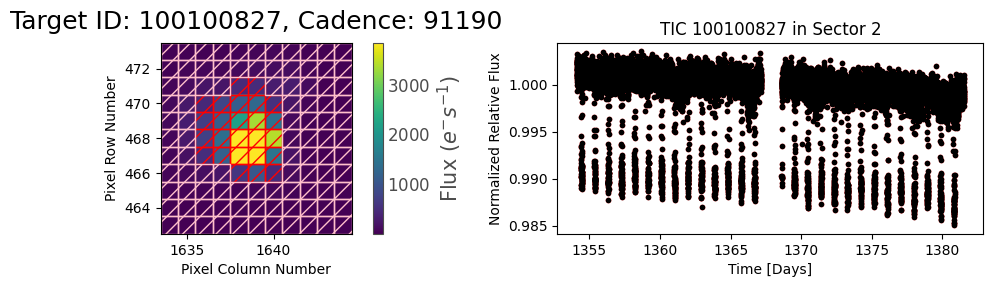

window size (days):  1.1551602860349437


/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_5175/1235472600.py:250: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_5175/1235472600.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_5175/1235472600.py:252: FutureWarning: 

BLS period is  0.9414244595824229 d
BLS reference time is 1354.4597273766335
BLS duration is 0.07863034852905566 d



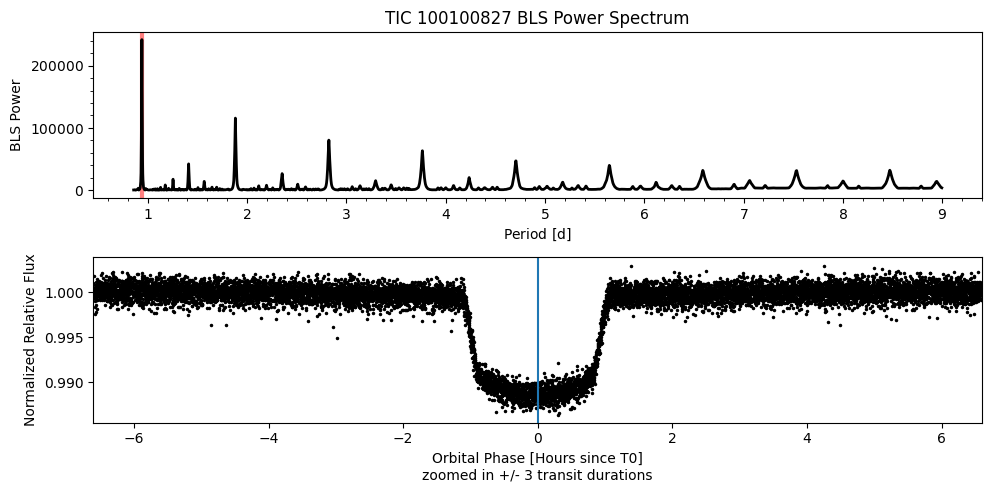

In [20]:


starname='TIC 100100827'
author='SPOC'
save_directory=os.getcwd()+'/smoothing_practice/'

#selecting photometry settings
mask_threshold=5
nsigma=2

#selecting smoothing settings
window_size_in_days=None
filter_type='biweight'

#selecting period range to search over
min_period=0.5
max_period=9
# N_periods=10000

#selection duration range to search over
# min_dur=0.05
# max_dur=1
# N_durations=10
oversampling_factor=9
duration_grid_step=1.05
# frequency_factor=500

#debugging mode
verbose=True

#old code
# output_lc, planet_period, planet_t0, planet_dur = pipeline(starname, author, mask_threshold, nsigma, save_directory,
#                                                           window_size_in_days,filter_type,
#                                                           min_period,max_period,N_periods,
#                                                           min_dur, max_dur, N_durations,
#                                                           frequency_factor,verbose)


output_lc, planet_period, planet_t0, planet_dur = pipeline(starname, author, mask_threshold, nsigma, save_directory,
                                                   window_size_in_days,filter_type,
                                                   min_period,max_period, oversampling_factor,
                                                   duration_grid_step,verbose)

# test it out with too large Window size

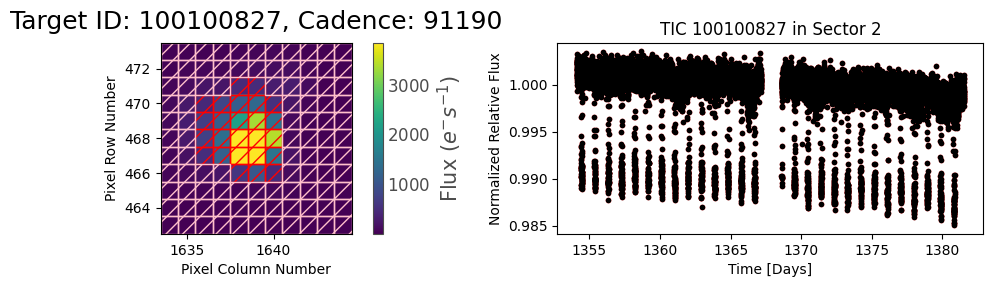

window size (days):  100


/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_5175/1235472600.py:250: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_5175/1235472600.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_5175/1235472600.py:252: FutureWarning: 

BLS period is  0.9414244595824229 d
BLS reference time is 1354.4597273766335
BLS duration is 0.07863034852905566 d



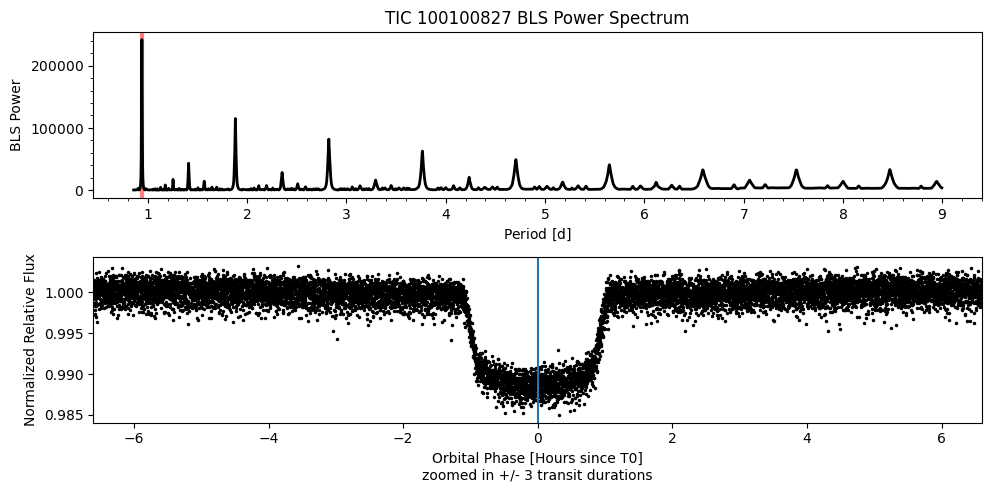

In [21]:




starname='TIC 100100827'
author='SPOC'
save_directory=os.getcwd()+'/smoothing_practice/'

#selecting photometry settings
mask_threshold=5
nsigma=2

#selecting smoothing settings
window_size_in_days=100
filter_type='biweight'

#selecting period range to search over
min_period=0.5
max_period=9
# N_periods=10000

#selection duration range to search over
# min_dur=0.05
# max_dur=1
# N_durations=10
oversampling_factor=9
duration_grid_step=1.05
# frequency_factor=500

#debugging mode
verbose=True

#old code
# output_lc, planet_period, planet_t0, planet_dur = pipeline(starname, author, mask_threshold, nsigma, save_directory,
#                                                           window_size_in_days,filter_type,
#                                                           min_period,max_period,N_periods,
#                                                           min_dur, max_dur, N_durations,
#                                                           frequency_factor,verbose)


output_lc, planet_period, planet_t0, planet_dur = pipeline(starname, author, mask_threshold, nsigma, save_directory,
                                                   window_size_in_days,filter_type,
                                                   min_period,max_period, oversampling_factor,
                                                   duration_grid_step,verbose)

# test it out with too small Window size

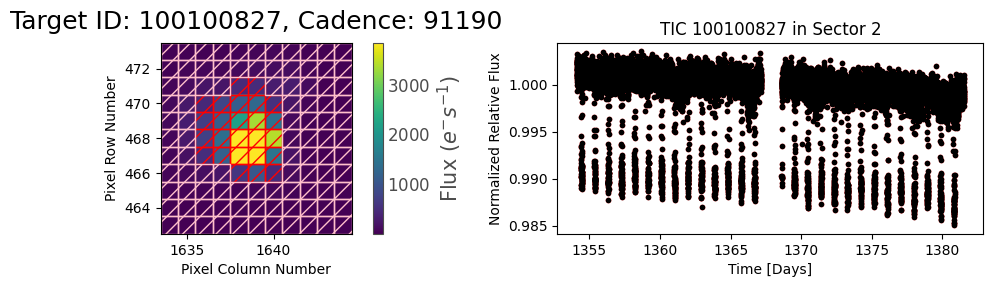

window size (days):  0.041666666666666664


/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_5175/1235472600.py:250: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_5175/1235472600.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_5175/1235472600.py:252: FutureWarning: 

BLS period is  0.9414244595824229 d
BLS reference time is 1354.4597273766335
BLS duration is 0.07863034852905566 d



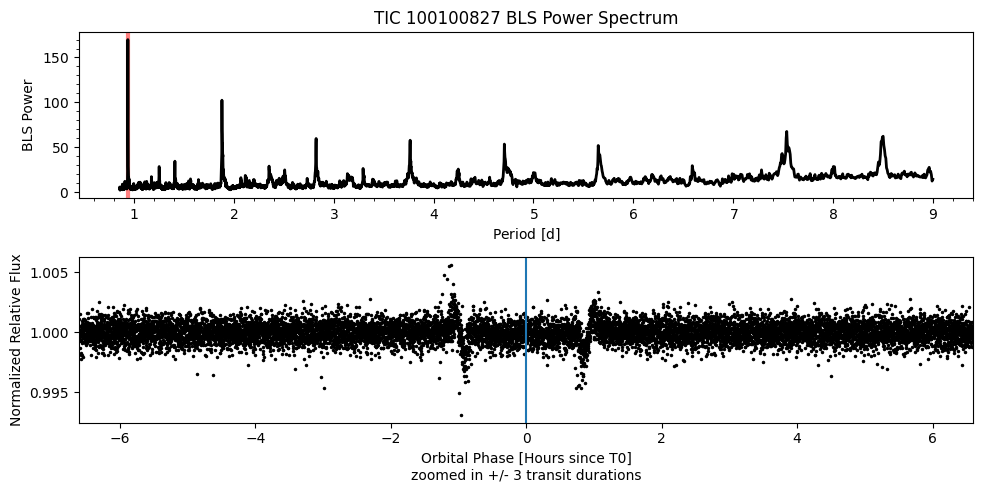

In [22]:


starname='TIC 100100827'
author='SPOC'
save_directory=os.getcwd()+'/smoothing_practice/'

#selecting photometry settings
mask_threshold=5
nsigma=2

#selecting smoothing settings
window_size_in_days=1/24
filter_type='biweight'

#selecting period range to search over
min_period=0.5
max_period=9
# N_periods=10000

#selection duration range to search over
# min_dur=0.05
# max_dur=1
# N_durations=10
oversampling_factor=9
duration_grid_step=1.05
# frequency_factor=500

#debugging mode
verbose=True

#old code
# output_lc, planet_period, planet_t0, planet_dur = pipeline(starname, author, mask_threshold, nsigma, save_directory,
#                                                           window_size_in_days,filter_type,
#                                                           min_period,max_period,N_periods,
#                                                           min_dur, max_dur, N_durations,
#                                                           frequency_factor,verbose)


output_lc, planet_period, planet_t0, planet_dur = pipeline(starname, author, mask_threshold, 
                                                           nsigma, save_directory,
                                                           window_size_in_days,filter_type,
                                                           min_period,max_period, oversampling_factor,
                                                           duration_grid_step,verbose)

# Next, for our blind transit survey, we have to think about how to handle multi-sector light curves. In our current "extract_TESS_photometry" code, it is set up to extract a light curve for whatever the first sector TESS observed a given target star is.

# Let's practice with searching for TESS data products with lightkurve

In [23]:
import lightkurve as lk
print(starname)

search_result = lk.search_targetpixelfile(starname)
search_result

TIC 100100827


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,100100827,0.0
1,TESS Sector 03,2018,SPOC,120,100100827,0.0
2,TESS Sector 29,2020,SPOC,20,100100827,0.0
3,TESS Sector 30,2020,SPOC,20,100100827,0.0
4,TESS Sector 29,2020,SPOC,120,100100827,0.0
5,TESS Sector 30,2020,SPOC,120,100100827,0.0
6,TESS Sector 69,2023,SPOC,20,100100827,0.0
7,TESS Sector 69,2023,SPOC,120,100100827,0.0
8,TESS Sector 02,2018,TESS-SPOC,1800,100100827,0.0


# As you can see, there are many results from the "author" called SPOC and TESS-SPOC. Notice also the difference in avaiability in not just TESS Sector ## but also in "exptime" or exposure time.

# For this target, all SPOC lightcurves have either 120s or 20s cadences (exposure times).

# All TESS-SPOC lightcurves have either 1800s or 600s cadences.

# In the primary TESS mission (Sectors 1 - 26), stars have either 120s or 1800s cadences. Typically stars brighter than 13.5 TESS magnitude have both options. Stars fainter than 13.5 only have 1800s cadence images.

# In the Extended TESS mission (Sectors > 26), stars have improved time resolution and lower cadence options: 20s and 600s. The same deal applies where bright stars will have 20s, 120s and 600s cadence data but faint stars only will have 600s cadence data. A handful of stars were pre-selected to have 20s cadences.

# With that in mind, we can also filter based on exposure time (or cadence)

In [24]:
search_result = lk.search_targetpixelfile(starname,exptime=20)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 29,2020,SPOC,20,100100827,0.0
1,TESS Sector 30,2020,SPOC,20,100100827,0.0
2,TESS Sector 69,2023,SPOC,20,100100827,0.0


In [25]:
search_result = lk.search_targetpixelfile(starname,exptime=120)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,100100827,0.0
1,TESS Sector 03,2018,SPOC,120,100100827,0.0
2,TESS Sector 29,2020,SPOC,120,100100827,0.0
3,TESS Sector 30,2020,SPOC,120,100100827,0.0
4,TESS Sector 69,2023,SPOC,120,100100827,0.0


In [26]:
search_result = lk.search_targetpixelfile(starname,exptime=600)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 29,2020,TESS-SPOC,600,100100827,0.0
1,TESS Sector 30,2020,TESS-SPOC,600,100100827,0.0


In [27]:
search_result = lk.search_targetpixelfile(starname,exptime=1800)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,TESS-SPOC,1800,100100827,0.0
1,TESS Sector 03,2018,TESS-SPOC,1800,100100827,0.0


# For our work, let's create code that will search for 120s cadence data but opt for 1800s cadence data if no 120s cadence data is available

In [28]:
def download_data(starname,mission,quarter_number,cadence,verbose=True):
    from lightkurve.search import _search_products
    from lightkurve.search import SearchError

    degrees = 21/3600 #size of TESS pixels in degrees on the sky
    
    if mission=='TESS':
        if (cadence=='long') or (cadence=='30 minute') or (cadence=='10 minute'):
                ffi_or_tpf='FFI'
        if (cadence=='short') or (cadence=='2 minute') or (cadence=='20 second') or (cadence=='fast'):
            ffi_or_tpf='Target Pixel'
    if mission=='Kepler':
        if (cadence=='long') or (cadence=='30 minute') or (cadence=='10 minute'):
            ffi_or_tpf='FFI'
        if (cadence=='short') or (cadence=='2 minute') or (cadence=='20 second') or (cadence=='fast'):
            ffi_or_tpf='Target Pixel'        
    
    if mission=='TESS':
        try:
#             search_string=_search_products(starname, radius=degrees,\
#                                            filetype=ffi_or_tpf, \
#                                            cadence=cadence,\
#                                            mission=mission,sector=quarter_number)
            search_string = lk.search_targetpixelfile(starname,cadence=cadence)
        except SearchError as e:
            print('No ',cadence,' cadence ',mission,' data for ',starname,' in Sector ',quarter_number,'!')
            return None
    if mission=='Kepler':
        search_string = lk.search_targetpixelfile(starname,author=mission, \
                              quarter=quarter_number,\
                              exptime=cadence)
        search_string=search_string[search_string.author==mission]
    #
    # #NEW
    if verbose==True:
        if mission=='TESS':        
            print('Number of data products for ',starname,' in ',mission,' with ',cadence,' cadence and in Sector ',quarter_number,':',len(search_string.exptime.value))
        if mission=='Kepler':        
            print('Number of data products for ',starname,' in ',mission,' with ',cadence,' cadence and in Quarter ',quarter_number,':',len(search_string.exptime.value))        
    # # NEW
    #
    # filter search result by cadence input argument
    if (cadence=='30 minute') or (cadence=='long'):
        mask = np.where((search_string.exptime.value>600) & (search_string.exptime.value<=1800) )[0]
        search_string_filtered = search_string[mask]
    if (cadence=='10 minute'):
        mask = np.where((search_string.exptime.value>120) & (search_string.exptime.value<=600) )[0]
        search_string_filtered = search_string[mask]
    if (cadence=='2 minute') or (cadence=='short'):
        mask = np.where((search_string.exptime.value>20) & (search_string.exptime.value<=120) )[0]
        search_string_filtered = search_string[mask]
    if (cadence=='20 second') or (cadence=='fast'):
        mask = np.where((search_string.exptime.value>0) & (search_string.exptime.value<=20) )[0]
        search_string_filtered = search_string[mask]
        
    #make sure there are no duplicate quarters/sectors
    u, indices = np.unique(search_string_filtered.mission, return_index=True)
    search_string_filtered = search_string_filtered[indices]
    # # NEW    
    # # NEW    
    return search_string_filtered

Sector=None
search_result=download_data(starname,mission='TESS',
                            quarter_number=Sector,
                            cadence='2 minute',verbose=False)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,100100827,0.0
1,TESS Sector 03,2018,SPOC,120,100100827,0.0
2,TESS Sector 29,2020,SPOC,120,100100827,0.0
3,TESS Sector 30,2020,SPOC,120,100100827,0.0
4,TESS Sector 69,2023,SPOC,120,100100827,0.0


# we can also specify specific sectors if we want:

In [29]:
#for example Sector 2
Sector=2
search_result=download_data(starname,mission='TESS',
                            quarter_number=Sector,
                            cadence='2 minute')
search_result

Number of data products for  TIC 100100827  in  TESS  with  2 minute  cadence and in Sector  2 : 12


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,100100827,0.0
1,TESS Sector 03,2018,SPOC,120,100100827,0.0
2,TESS Sector 29,2020,SPOC,120,100100827,0.0
3,TESS Sector 30,2020,SPOC,120,100100827,0.0
4,TESS Sector 69,2023,SPOC,120,100100827,0.0


# However, we want to use all available data, so we'll set Sector=None

# We can also query by cadence:

In [30]:
Sector=None
search_result=download_data(starname,mission='TESS',
                            quarter_number=Sector,
                            cadence='2 minute')
search_result

Number of data products for  TIC 100100827  in  TESS  with  2 minute  cadence and in Sector  None : 12


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,100100827,0.0
1,TESS Sector 03,2018,SPOC,120,100100827,0.0
2,TESS Sector 29,2020,SPOC,120,100100827,0.0
3,TESS Sector 30,2020,SPOC,120,100100827,0.0
4,TESS Sector 69,2023,SPOC,120,100100827,0.0


In [31]:
Sector=None
search_result=download_data(starname,mission='TESS',
                            quarter_number=Sector,
                            cadence='10 minute')
search_result

Number of data products for  TIC 100100827  in  TESS  with  10 minute  cadence and in Sector  None : 12


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 29,2020,TESS-SPOC,600,100100827,0.0
1,TESS Sector 30,2020,TESS-SPOC,600,100100827,0.0


In [32]:
Sector=None
search_result=download_data(starname,mission='TESS',
                            quarter_number=Sector,
                            cadence='30 minute')
search_result

Number of data products for  TIC 100100827  in  TESS  with  30 minute  cadence and in Sector  None : 12


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,TESS-SPOC,1800,100100827,0.0
1,TESS Sector 03,2018,TESS-SPOC,1800,100100827,0.0


In [33]:
Sector=None
search_result=download_data(starname,mission='TESS',
                            quarter_number=Sector,
                            cadence='20 second')
search_result

Number of data products for  TIC 100100827  in  TESS  with  20 second  cadence and in Sector  None : 12


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 29,2020,SPOC,20,100100827,0.0
1,TESS Sector 30,2020,SPOC,20,100100827,0.0
2,TESS Sector 69,2023,SPOC,20,100100827,0.0


In [34]:
# Now, let's say there are no 120s cadence data available. We can do a length check and try again with a higher cadence.
print(len(search_result))
print(' ')

fake_search_result = []#search_result
print(len(fake_search_result))
print(' ')

N_data_products=len(fake_search_result)
while N_data_products<1:
    # see which LC has the most data
    search_result_20s=download_data(starname,mission='TESS',
                                    quarter_number=Sector,
                                    cadence='20 second',verbose=False)
    search_result_10m=download_data(starname,mission='TESS',
                                    quarter_number=Sector,
                                    cadence='10 minute',verbose=False)
    search_result_30m=download_data(starname,mission='TESS',
                                    quarter_number=Sector,
                                    cadence='30 minute',verbose=False)
    #
    results=[len(search_result_20s), len(search_result_10m),len(search_result_30m)]
    most_data_index = np.argmax(results)
    if most_data_index==0:
        print('most data for 20s cadence')
        most_data = search_result_20s
    if most_data_index==1:
        print('most data for 10m cadence')
        most_data = search_result_10m
    if most_data_index==2:
        print('most data for 30m cadence')        
        most_data = search_result_30m
    N_data_products+=len(most_data)
    
    fake_search_result = most_data
    break
fake_search_result

3
 
0
 
most data for 20s cadence


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 29,2020,SPOC,20,100100827,0.0
1,TESS Sector 30,2020,SPOC,20,100100827,0.0
2,TESS Sector 69,2023,SPOC,20,100100827,0.0


# so now that we have all these observations, how do we go about creating multi-sector light curves?

In [35]:
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 29,2020,SPOC,20,100100827,0.0
1,TESS Sector 30,2020,SPOC,20,100100827,0.0
2,TESS Sector 69,2023,SPOC,20,100100827,0.0


In [36]:
tpfs = search_result.download_all()
tpf  = search_result[0].download() #just the first result

# using download_all() instead of download() is the trick!

# However, this is not a targetpixelfile (TPF), it is a targetpixelfilecollection, so normal tpf usage has to be adjusted:

In [37]:
print(type(tpfs))
print(type(tpf))


<class 'lightkurve.collections.TargetPixelFileCollection'>
<class 'lightkurve.targetpixelfile.TessTargetPixelFile'>


# so we have to then do a for-loop, where we process each light curve individually and then combine them in the end. 


# Unlike before where we had smoothing separated from our initial light curve extraction, we will name have them together. So we'll have to redo our order of operations a bit. 

# Making a function is probably the easy way to go!

window size (days):  0.041666666666666664


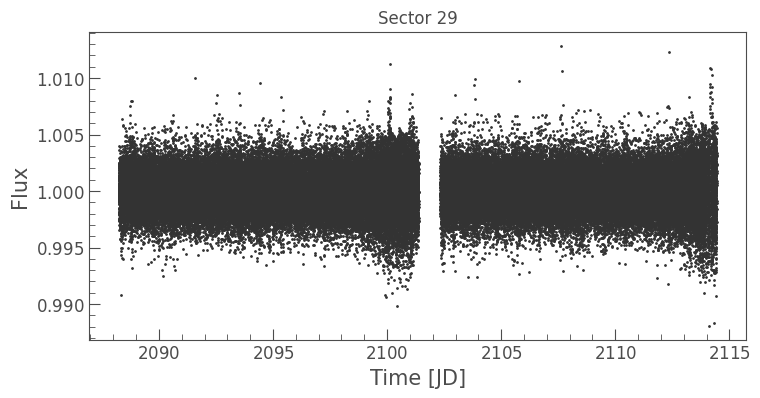

0
window size (days):  0.041666666666666664


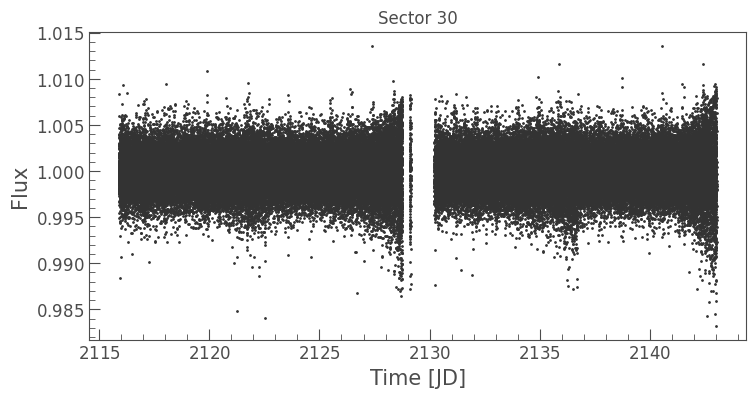

1
window size (days):  0.041666666666666664


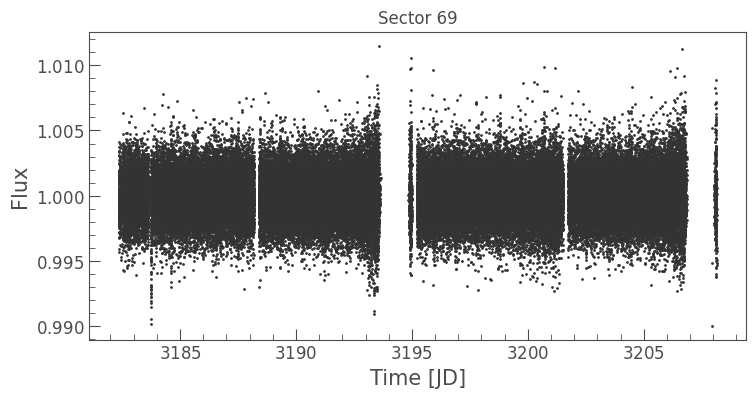

2


In [38]:

for t in range(len(tpfs)):
    tpf = tpfs[t]
    #Step 2: Perform aperture photometry
    if mask_threshold is None:
        pixel_mask = tpf.pipeline_mask
        background_mask = ~tpf.pipeline_mask
    if mask_threshold is not None:
        pixel_mask = tpf.create_threshold_mask(threshold=mask_threshold)
        background_mask = ~tpf.create_threshold_mask(threshold=mask_threshold)

    lc = tpf.to_lightcurve(aperture_mask=pixel_mask)
    bkg = tpf.to_lightcurve(aperture_mask=background_mask)
    
    #Step 3: Perform Background Subtraction and Normalization
    bkg_subtracted_flux=lc.flux.value - bkg.flux.value
    
    #create new "LightCurve" object
    bkg_subtracted_lc = lk.LightCurve(time=lc.time.value,
                                      flux=bkg_subtracted_flux,
                                      flux_err = lc.flux_err.value)
    
    # normalize the background subtracted light curve
    normalized_bkg_subtracted_lc =  bkg_subtracted_lc.normalize()
    
    outlier_removed_normalized_bkg_subtracted_lc = normalized_bkg_subtracted_lc.remove_outliers(sigma_upper=nsigma)
    # rename
    input_lc = outlier_removed_normalized_bkg_subtracted_lc
    
    # Rename output light curve from Step 1:
    input_lc = outlier_removed_normalized_bkg_subtracted_lc
    
    # Step 2: Smoothing light curve before transit searching (NEW STEP)
    ID=int(starname[4:]) #assuming it begins with 'TIC '
    smoothed_lc,trend_lc = smoothing_function(ID,input_lc,
                                              window_size_in_days=window_size_in_days,
                                              verbose=verbose,filter_type=filter_type)
    smoothed_lc.scatter()
    plt.title('Sector '+str(tpf.sector))
    plt.show()
    if t==0:
        output_lc = smoothed_lc    
    print(t)
    if t>0:        
        output_lc = output_lc.append(smoothed_lc)
    

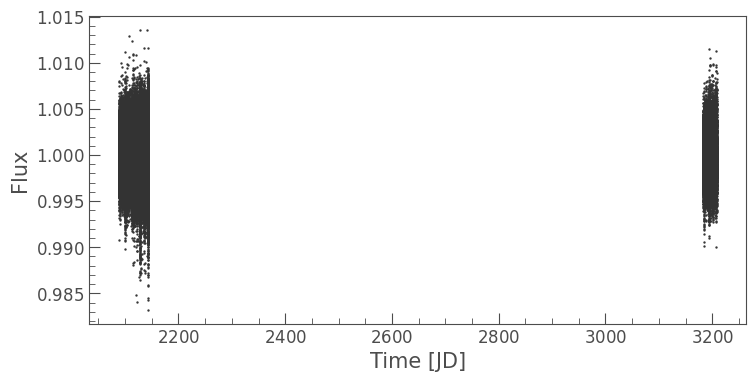

In [39]:
output_lc.scatter(s=2)
plt.show()

Number of data products for  TIC 100100827  in  TESS  with  2 minute  cadence and in Sector  None : 12


window size (days):  1.1551602860349437
0
window size (days):  1.045038666907606
1
window size (days):  1.137898697010797
2
window size (days):  1.1508465405212769
3
window size (days):  1.1319470884594454
4


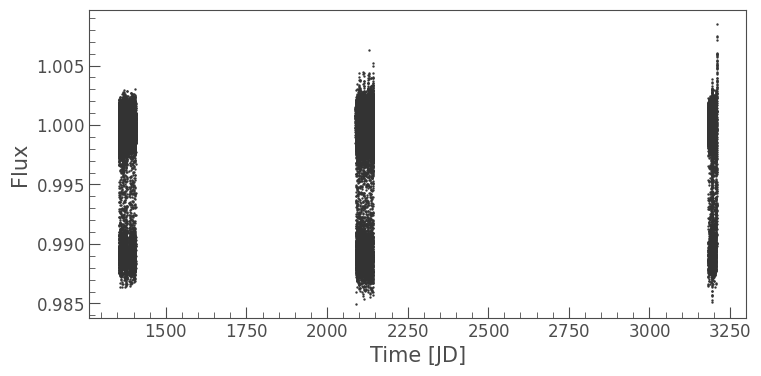

In [40]:
def extract_TESS_photometry_and_smooth(starname,author,nsigma,
                                       save_directory, mask_threshold=None,
                                       Sector=None, window_size_in_days=None,
                                       verbose=True,
                                       filter_type='biweight'):
    
    #Step 0: collect TESS images
    search_result=download_data(starname,mission='TESS',
                                quarter_number=Sector,cadence='2 minute')
    
    N_data_products=len(search_result)
    while N_data_products<1:
        # see which LC has the most data
        search_result_20s=download_data(starname,mission='TESS',
                                        quarter_number=Sector,
                                        cadence='20 second',verbose=False)
        search_result_10m=download_data(starname,mission='TESS',
                                        quarter_number=Sector,
                                        cadence='10 minute',verbose=False)
        search_result_30m=download_data(starname,mission='TESS',
                                        quarter_number=Sector,
                                        cadence='30 minute',verbose=False)
        #
        results=[len(search_result_20s), len(search_result_10m),len(search_result_30m)]
        most_data_index = np.argmax(results)
        if most_data_index==0:
            print('most data for 20s cadence')
            most_data = search_result_20s
        if most_data_index==1:
            print('most data for 10m cadence')
            most_data = search_result_10m
        if most_data_index==2:
            print('most data for 30m cadence')        
            most_data = search_result_30m
        N_data_products+=len(most_data)

        search_result = most_data
        break        
    
    tpfs = search_result.download_all()
    #Step 1: extract and smooth TESS data
    for t in range(len(tpfs)):
        tpf = tpfs[t]
        #Step 2: Perform aperture photometry
        if mask_threshold is None:
            pixel_mask = tpf.pipeline_mask
            background_mask = ~tpf.pipeline_mask
        if mask_threshold is not None:
            pixel_mask = tpf.create_threshold_mask(threshold=mask_threshold)
            background_mask = ~tpf.create_threshold_mask(threshold=mask_threshold)

        lc = tpf.to_lightcurve(aperture_mask=pixel_mask)
        bkg = tpf.to_lightcurve(aperture_mask=background_mask)

        #Step 3: Perform Background Subtraction and Normalization
        bkg_subtracted_flux=lc.flux.value - bkg.flux.value

        #create new "LightCurve" object
        bkg_subtracted_lc = lk.LightCurve(time=lc.time.value,
                                          flux=bkg_subtracted_flux,
                                          flux_err = lc.flux_err.value)

        # normalize the background subtracted light curve
        normalized_bkg_subtracted_lc =  bkg_subtracted_lc.normalize()

        outlier_removed_normalized_bkg_subtracted_lc = normalized_bkg_subtracted_lc.remove_outliers(sigma_upper=nsigma)
        # rename
        input_lc = outlier_removed_normalized_bkg_subtracted_lc

        # Rename output light curve from Step 1:
        input_lc = outlier_removed_normalized_bkg_subtracted_lc

        # Step 2: Smoothing light curve before transit searching (NEW STEP)
        ID=int(starname[4:]) #assuming it begins with 'TIC '
        smoothed_lc,trend_lc = smoothing_function(ID,input_lc,
                                                  window_size_in_days=window_size_in_days,
                                                  verbose=verbose,filter_type=filter_type)
#         smoothed_lc.scatter()
    #     plt.title('Sector '+str(tpf.sector))
    #     plt.show()
        if t==0:
            output_lc = smoothed_lc    
        print(t)
        if t>0:        
            output_lc = output_lc.append(smoothed_lc)
        
    return output_lc
    
    
o=extract_TESS_photometry_and_smooth(starname,author,nsigma,
                                       save_directory, mask_threshold=None,
                                       Sector=None, window_size_in_days=None,
                                       verbose=True,
                                       filter_type='biweight')    
o.scatter(s=2)
plt.show()

# Our other functions after LC processing should now work as originally planned

# Once again, let's update our code (again, this will be stored on https://github.com/daxfeliz/SRMP_Project_2024/blob/main/lightcurve_practice_code.py)

In [41]:
import os
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

def download_data(starname,mission,quarter_number,cadence,verbose=True):
    from lightkurve.search import _search_products

    degrees = 21/3600 #size of TESS pixels in degrees on the sky
    
    if mission=='TESS':
        if (cadence=='long') or (cadence=='30 minute') or (cadence=='10 minute'):
                ffi_or_tpf='FFI'
        if (cadence=='short') or (cadence=='2 minute') or (cadence=='20 second') or (cadence=='fast'):
            ffi_or_tpf='Target Pixel'
    if mission=='Kepler':
        if (cadence=='long') or (cadence=='30 minute') or (cadence=='10 minute'):
            ffi_or_tpf='FFI'
        if (cadence=='short') or (cadence=='2 minute') or (cadence=='20 second') or (cadence=='fast'):
            ffi_or_tpf='Target Pixel'        
    
    if mission=='TESS':
        try:
            search_string=_search_products(starname, radius=degrees,\
                                           filetype=ffi_or_tpf, \
                                           cadence=cadence,\
                                           mission=mission,sector=quarter_number)
        except SearchError as e:
            print('No ',cadence,' cadence ',mission,' data for ',starname,' in Sector ',quarter_number,'!')
            return None
    if mission=='Kepler':
        search_string = lk.search_targetpixelfile(starname,author=mission, \
                              quarter=quarter_number,\
                              exptime=cadence)
        search_string=search_string[search_string.author==mission]
    #
    # #NEW
    if verbose==True:
        if mission=='TESS':        
            print('Number of data products for ',starname,' in ',mission,' with ',cadence,' cadence and in Sector ',quarter_number,':',len(search_string.exptime.value))
        if mission=='Kepler':        
            print('Number of data products for ',starname,' in ',mission,' with ',cadence,' cadence and in Quarter ',quarter_number,':',len(search_string.exptime.value))        
    # # NEW
    #
    # filter search result by cadence input argument
    if (cadence=='30 minute') or (cadence=='long'):
        mask = np.where((search_string.exptime.value>600) & (search_string.exptime.value<=1800) )[0]
        search_string_filtered = search_string[mask]
    if (cadence=='10 minute'):
        mask = np.where((search_string.exptime.value>120) & (search_string.exptime.value<=600) )[0]
        search_string_filtered = search_string[mask]
    if (cadence=='2 minute') or (cadence=='short'):
        mask = np.where((search_string.exptime.value>20) & (search_string.exptime.value<=120) )[0]
        search_string_filtered = search_string[mask]
    if (cadence=='20 second') or (cadence=='fast'):
        mask = np.where((search_string.exptime.value>0) & (search_string.exptime.value<=20) )[0]
        search_string_filtered = search_string[mask]
        
    #make sure there are no duplicate quarters/sectors
    u, indices = np.unique(search_string_filtered.mission, return_index=True)
    search_string_filtered = search_string_filtered[indices]
    # # NEW    
    return search_string_filtered

def catalog_info(TIC_ID):
    """Takes TIC_ID, returns stellar information from online catalog using Vizier.
    Input Parameters
    ----------
    TIC_ID : int
        TESS Input Catalog ID number to search for and analyze.
        
    Returns
    -------
        A list of select stellar parameters.
        * (a,b): quadratic limb darkening coefficients cross-matched from 
        limb darkening Claret et al. (2012) tables based on Effective Temperature
        and Surface Gravity of target star (according to the TIC).
        * mass: Stellar Mass (from the TIC) in units of solar masses.
        * mass_min, mass_max: Uncertainty of Stellar Mass (from the TIC) in units of solar masses.
        * radius: Stellar Radius (from the TIC) in units of solar radii.
        * radius_min, radius_max: Uncertainty of Stellar Radius (from the TIC) in units of solar radii.
          
    """
    import requests
    import numpy
    from os import path
    import time as clock
    try:
        from astroquery.mast import Catalogs
    except:
        raise ImportError("Package astroquery required but failed to import")
    #
    #
    #
    result = Catalogs.query_criteria(catalog="Tic", ID=TIC_ID).as_array()
    Teff = float(result['Teff'].data)
    logg = float(result['logg'].data)
    radius = float(result['rad'].data)
    radius_max = float(result['e_rad'].data)
    radius_min = float(result['e_rad'].data)
    mass = float(result['mass'].data)
    mass_max = float(result['e_mass'].data)
    mass_min = float(result['e_mass'].data)
    
    return (mass, mass_min, mass_max, radius, radius_min, radius_max)

def SMA_AU_from_Period_to_stellar(Period,R_star,M_star):
    """
    This function will calculate the Semi-Major Axis (SMA)
    using Kepler's third law.
    
    Input Parameters
    ----------
    Period : float
        Orbital period in days
    R_star : float
        Stellar Radius in solar radii
    M_star : float
        Stellar Mass in solar masses
    Returns
    -------
        * SMA
            Semi-Major Axis in solar units
        * SMA_cm
            Semi-Major Axis in units of centimeters        
    """
    #assumes circular orbit
    #using Kepler's third law, calculate SMA
    #solar units
    import astropy.units as u
    from astropy import constants as const
    RS = u.R_sun.to(u.cm) # in cm
    MS = u.M_sun.to(u.g) # in grams
    #
    G = const.G.cgs.value #cm^3 per g per s^2
    #
    R = R_star*RS
    M = M_star*MS
    P=Period*60.0*24.0*60.0 #in seconds
    #
    #SMA
    SMA_cm = ((G*M*(P**2))/(4*(np.pi**2)))**(1/3)
    #
    #note R_star is already in solar units so we need to convert to cm using
    # solar radius as a constant
    Stellar_Radius = R #now in cm
    #
    SMA = SMA_cm / Stellar_Radius #now unitless (cm / cm)
    return SMA, SMA_cm

def Tdur(Period, R_star,M_star, R_planet_RE):
    """
    This function will calculate the transit duration
    time based on Kepler's third law. 
    Input Parameters
    ----------
    Period : float
        Orbital period in days
    R_star : float
        Stellar Radius in Solar radii
    M_star : float
        Stellar Mass in Solar masses
    R_planet_RE: float
        Planet radius in Earth Radii

    Returns
    -------
        * Tdur : float
            Estimated transit duration time in units of days
    """
    from astropy import units as u

    RE = u.R_earth.to(u.cm) # in cm
    RS = u.R_sun.to(u.cm) # in cm
    A = Period/np.pi #in days
    #
    SMA_cm = SMA_AU_from_Period_to_stellar(Period,R_star,M_star)[1]
    #
    B =(R_star*RS +R_planet_RE*RE)/ SMA_cm # unitless (cm/cm)
    #
    T_dur = A*np.arcsin(B) #in days
    return T_dur    

def smoothing_function(ID,input_LC,window_size_in_days=None,verbose=True,filter_type='biweight'):
    """   
    This function will smooth the input light curve. If no window size is
    provided, a window size corresponding to 3 times the transit duration
    of an Earth-sized planet eclipsing this target star will be used.
    Input Parameters
    ----------
    ID : int
        TESS Input Catalog identification number
    input_LC : pandas dataframe
        Input NEMESIS light curve to be smoothed
    window_size_in_days : float or None
        Desired smoothing window in units of days. Default is set to None.
    verbose : boolean
        This flag is used to print the window size used for smoothing.
    Returns
     -------
    * newlc : Lightkurve LightCurve object
        This Detrended Light Curve contains the follow column names:
        * time
        * flux #this is detrended flux
        * flux_err #this is detrended flux error
    * trend : Lightkurve LightCurve object
        This trend Light Curve contains the follow column names:
        * time
        * flux #this is smoothed lightcurve trend line
        * flux_err #this is detrended flux error (same as input_LC.flux_err)
    """
    from wotan import flatten
    import numpy as np
    import lightkurve as lk
    #
    #
    #read in LC data
    time = input_LC.time.value
    flux_raw = input_LC.flux.value
    flux_error = input_LC.flux_err.value
    #
    if window_size_in_days==None:
        LCDur=(np.nanmax(time) - np.nanmin(time))
        maxP = LCDur/2 #longest period for 2 transits in a light curve (~14 days for TESS single sector LCs)
        R_planet_RE = 1
        M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)
        window_size_in_days = 5*Tdur(maxP, R_star,M_star, R_planet_RE)
    if verbose==True:
        print('window size (days): ',window_size_in_days)
    flatten_lc, trend_lc = flatten(time, flux_raw, window_length=window_size_in_days, \
                                   return_trend=True, method=filter_type,robust=True)
    T=time
    F=flatten_lc
    FE=flux_error
    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]
    F_raw = flux_raw[nanmask]
    trend_lc=trend_lc[nanmask]
    newlc = lk.LightCurve(time=T,flux=F,flux_err=FE)
    trend = lk.LightCurve(time=time[nanmask],flux=trend_lc,flux_err=flux_error[nanmask])
    return newlc, trend


def extract_TESS_photometry_and_smooth(starname,author,nsigma,
                                       save_directory, mask_threshold=None,
                                       Sector=None, window_size_in_days=None,
                                       verbose=True,
                                       filter_type='biweight',max_sector=26):
    
    #Step 0: collect TESS images
    search_result=download_data(starname,mission='TESS',
                                quarter_number=Sector,cadence='2 minute')
    
    N_data_products=len(search_result)
    while N_data_products<1:
        # see which LC has the most data
        search_result_20s=download_data(starname,mission='TESS',
                                        quarter_number=Sector,
                                        cadence='20 second',verbose=False)
        search_result_10m=download_data(starname,mission='TESS',
                                        quarter_number=Sector,
                                        cadence='10 minute',verbose=False)
        search_result_30m=download_data(starname,mission='TESS',
                                        quarter_number=Sector,
                                        cadence='30 minute',verbose=False)
        #
        results=[len(search_result_20s), len(search_result_10m),len(search_result_30m)]
        most_data_index = np.argmax(results)
        if most_data_index==0:
            print('most data for 20s cadence')
            most_data = search_result_20s
        if most_data_index==1:
            print('most data for 10m cadence')
            most_data = search_result_10m
        if most_data_index==2:
            print('most data for 30m cadence')        
            most_data = search_result_30m
        N_data_products+=len(most_data)

        search_result = most_data
        break        
        
    def get_primary_mission_sectors(search_string,last_updated_sector=26):
        #find what available TESS sectors are able to be processed by our code:
        mask = np.where(np.array(list(map(int, [x[-2:] for x in search_string.mission])))<int(last_updated_sector))[0]
        imask = np.where(np.array(list(map(int, [x[-2:] for x in search_string.mission])))>int(last_updated_sector))[0]
        print('Our code is currently coded to handle TESS Sectors 1-26. ', 
              np.unique(search_string[imask].mission),
              'light curves are not yet available.')
        print(' ')
        return search_string[mask]

    search_result = get_primary_mission_sectors(search_result)
    print('processing',len(search_result),'data products:')
    Sectors=np.unique(search_result.mission)
    print(np.unique(search_result.mission))
    print(' ')
    Sectors_str=[]
    for ss in Sectors:
        Sectors_str=np.append(Sectors_str,str(int(ss[-2:])))    
    Sectors_str=','.join(Sectors_str)
    
    tpfs = search_result.download_all(bitmask_quality='hardest')
    #Step 1: extract and smooth TESS data
    for t in range(len(tpfs)):
        tpf = tpfs[t]
        #Step 2: Perform aperture photometry
        if mask_threshold is None:
            pixel_mask = tpf.pipeline_mask
            background_mask = ~tpf.pipeline_mask
        if mask_threshold is not None:
            pixel_mask = tpf.create_threshold_mask(threshold=mask_threshold)
            background_mask = ~tpf.create_threshold_mask(threshold=mask_threshold)

        quality_mask = tpf.quality==0
        lc = tpf.to_lightcurve(aperture_mask=pixel_mask)
        bkg = tpf.to_lightcurve(aperture_mask=background_mask)
        lc = lc[quality_mask]
        bkg = bkg[quality_mask]

        #Step 3: Perform Background Subtraction and Normalization
        bkg_subtracted_flux=lc.flux.value - bkg.flux.value

        #create new "LightCurve" object
        bkg_subtracted_lc = lk.LightCurve(time=lc.time.value,
                                          flux=bkg_subtracted_flux,
                                          flux_err = lc.flux_err.value)

        # normalize the background subtracted light curve
        normalized_bkg_subtracted_lc =  bkg_subtracted_lc.normalize()

        outlier_removed_normalized_bkg_subtracted_lc = normalized_bkg_subtracted_lc.remove_outliers(sigma_upper=nsigma)
        
        # rename
        input_lc = outlier_removed_normalized_bkg_subtracted_lc

        # Rename output light curve from Step 1:
        input_lc = outlier_removed_normalized_bkg_subtracted_lc

        # Step 2: Smoothing light curve before transit searching (NEW STEP)
        ID=int(starname[4:]) #assuming it begins with 'TIC '
        smoothed_lc,trend_lc = smoothing_function(ID,input_lc,
                                                  window_size_in_days=window_size_in_days,
                                                  verbose=verbose,filter_type=filter_type)
        #remove outliers again after smoothing
        #smoothed_lc.remove_outliers(sigma_upper=nsigma,sigma_lower=2*nsigma)
#         smoothed_lc.scatter()
    #     plt.title('Sector '+str(tpf.sector))
    #     plt.show()
        if t==0:
            normalized_bkg_subtracted_lcs=normalized_bkg_subtracted_lc
            outlier_removed_normalized_bkg_subtracted_lcs=outlier_removed_normalized_bkg_subtracted_lc
            output_lc = smoothed_lc    
        print(t)
        if t>0: 
            normalized_bkg_subtracted_lcs= normalized_bkg_subtracted_lcs.append(normalized_bkg_subtracted_lc)
            outlier_removed_normalized_bkg_subtracted_lcs= outlier_removed_normalized_bkg_subtracted_lcs.append(outlier_removed_normalized_bkg_subtracted_lc)
            output_lc = output_lc.append(smoothed_lc)
            
            
    # Step 4: Visualize the light curve
    fig=plt.figure(figsize=(10,5))
    ax1=fig.add_subplot(221)
    ax2=fig.add_subplot(222)
    
    tpf.plot(aperture_mask=pixel_mask,mask_color='red',
             ax=ax1,show_colorbar=True)
    tpf.plot(aperture_mask=background_mask,mask_color='pink',
             ax=ax1,show_colorbar=False)
    
    if len(Sectors_str)>1:
        ax2.set_title(starname+' in Sectors '+str(Sectors_str))
    else:
        ax2.set_title(starname+' in Sector '+str(Sectors_str))
    
    ax2.plot(normalized_bkg_subtracted_lcs.time.value,
             normalized_bkg_subtracted_lcs.flux.value,
           marker='.',color='red',linestyle='none')
    
    ax2.plot(outlier_removed_normalized_bkg_subtracted_lcs.time.value,
             outlier_removed_normalized_bkg_subtracted_lcs.flux.value,
           marker='.',color='black',linestyle='none')    
  
    ax2.set_xlabel('Time [Days]')
    ax2.set_ylabel('Normalized Relative Flux')
    fig.tight_layout(pad=1)
    plt.savefig(save_directory+starname+'_Sector_'+str(Sectors_str)+'_lightcurve.png',
                bbox_inches='tight')
    plt.show()            
        
    return output_lc,Sectors_str


def phasefold_version2(time,flux,flux_err,T0,Period):
    ''' 
    Version 2 is calculating the number of orbital cycles in 
    our light curve but is also shifted so that the phase value
    of 0 is at the T0 reference time.
    Input:
        time: array of timestamps
        flux: array of flux values
        flux_err: array of flux uncertainty values
        T0: float, reference time
        Period: float, orbital period
    Output:
        phase: array of phase values
        flux: array of flux values
        flux_err: array of flux uncertainty values
    '''    
    phase = (time - T0 + 0.5*Period) % Period - 0.5*Period
    ind = np.argsort(phase,axis=0)
    
    return phase[ind], flux[ind], flux_err[ind]

def fullphasefold(time,T0,period,flux,offset):
    """
    This function will phase-fold the input light curve (time, flux)
    using a Mid-transit time and orbital period.
    
    Input Parameters
    ----------
    time: array
        An array of timestamps from TESS observations.        
    TO : float
        The Mid-transit time of a periodic event.
    period : float
        An orbital period of a periodic event.
    flux : array
        An array of flux values from TESS observations.
    offset : int or float
        A value used to offset the phase by a fraction of an orbit.
        
    Returns
    -------
        * phase : array
            An array of Orbital phase of the phase-folded light curve.
        * flux : array
            An array of flux values from TESS observations of the 
            phase-folded light curve.
    """
    phase= (time - T0+ offset*period) / period - np.floor((time - T0+ offset*period) / period)
    ind=np.argsort(phase, axis=0)
    return phase[ind],flux[ind]
        
# grid functions for transit searching
# constants from transitleastsquares
#
# astrophysical constants
import astropy.units as u
from astropy import constants as const
R_sun = u.R_sun.to(u.cm) # in cm
M_sun = u.M_sun.to(u.g) # in grams
G = const.G.cgs.value #cm^3 per g per s^2
R_earth = u.R_earth.to(u.cm) # in cm
R_jup = u.R_jupiter.to(u.cm) # in cm
SECONDS_PER_DAY = u.day.to(u.second)


# For the duration grid
FRACTIONAL_TRANSIT_DURATION_MAX = 0.12
M_STAR_MIN = 0.1
M_STAR_MAX = 1.0
R_STAR_MIN = 0.13
R_STAR_MAX = 3.5
DURATION_GRID_STEP = 1.05
OVERSAMPLING_FACTOR = 5
N_TRANSITS_MIN = 3
MINIMUM_PERIOD_GRID_SIZE = 100

def T14(
    R_s, M_s, P, upper_limit=FRACTIONAL_TRANSIT_DURATION_MAX, small=False
):
    """Input:  Stellar radius and mass; planetary period
               Units: Solar radius and mass; days
       Output: Maximum planetary transit duration T_14max
               Unit: Fraction of period P"""
    import numpy
    
    pi = numpy.pi
    P = P * SECONDS_PER_DAY
    R_s = R_sun * R_s
    M_s = M_sun * M_s

    if small:  # small planet assumption
        T14max = R_s * ((4 * P) / (pi * G * M_s)) ** (1 / 3)
    else:  # planet size 2 R_jup
        T14max = (R_s + 2 * R_jup) * (
            (4 * P) / (pi * G * M_s)
        ) ** (1 / 3)

    result = T14max / P
    if result > upper_limit:
        result = upper_limit
    return result


def duration_grid(periods, shortest, log_step=DURATION_GRID_STEP):
    import numpy    
    duration_max = T14(
        R_s=R_STAR_MAX,
        M_s=M_STAR_MAX,
        P=numpy.min(periods),
        small=False  # large planet for long transit duration
    )
    duration_min = T14(
        R_s=R_STAR_MIN,
        M_s=M_STAR_MIN,
        P=numpy.max(periods),
        small=True  # small planet for short transit duration
    )

    durations = [duration_min]
    current_depth = duration_min
    while current_depth * log_step < duration_max:
        current_depth = current_depth * log_step
        durations.append(current_depth)
    durations.append(duration_max)  # Append endpoint. Not perfectly spaced.
    return durations
def find_min_trial_duration(input_LC,durations,periods):
    # this function takes the duration_grid and period_grid
    # provided by TLS' functions (which are based on stellar params)
    #
    def Special_Bin_func(time,flux,error,binsize):  #<-- doesn't allow empty bins to exist
        import math
        good = np.where(np.isfinite(time)) #finds values that are not +/- inf, NaN
        timefit = time[good]
        fluxfit = flux[good]
        errfit  = error[good]
        timemax = np.max(timefit)
        timemin = np.min(timefit)
        npoints = len(timefit)
        nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days
        bintime = np.full((nbins,), np.nan) #fills array with NaNs to be filled with values
        binflux = np.full((nbins,), np.nan)
        binerr  = np.full((nbins,), np.nan)
        for i in range(0,nbins-1):
            tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )]
            if len(tobin[0][0]) != 0:
                # inverse variance weighted means
                binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
                bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
                binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
        #
        return bintime, binflux, binerr
    #
    def calc_phase_coverage(input_LC,trial_duration,trial_period):
        t,f,e = input_LC.time.value, input_LC.flux.value, input_LC.flux_err.value
        T0 = np.nanmin(t)
        pf,ff,fe = phasefold_version2(t,f,e,T0,trial_period)
        binpf,binff,binfe = Special_Bin_func(pf,ff,e,binsize=trial_duration)
        ntotal=len(binpf)
        fin_bin = len(np.where(np.isfinite(binpf))[0])
        phase_coverage = fin_bin / ntotal
        return phase_coverage
    #
    # calculate phase coverage for input lightcurve
    phase_coverage = np.empty(np.size(durations))
    #do min P only
    for c in range(len(phase_coverage)):
        pc = calc_phase_coverage(input_LC,\
                                 trial_duration=durations[c],\
                                 trial_period=np.min(periods))
        phase_coverage[c] = pc
        
    q=0.25
    q_ind = np.where(phase_coverage==np.quantile(phase_coverage,q,interpolation='nearest'))[0][0]
    min_trial_duration = durations[q_ind]

    if min_trial_duration < (np.nanmedian(np.diff( input_LC.time.value ))/2 ):
        #print('min duration < half cadence!')
        min_trial_duration = (np.nanmedian(np.diff( input_LC.time.value )))/2

    durations=np.array(durations)
    new_durations = durations[durations>=min_trial_duration]
    new_durations = new_durations.tolist()
    
    return new_durations


def period_grid(
    R_star,
    M_star,
    time_span,
    period_min=0,
    period_max=float("inf"),
    oversampling_factor=OVERSAMPLING_FACTOR,
    n_transits_min=N_TRANSITS_MIN,
):
    """Returns array of optimal sampling periods for transit search in light curves
       Following Ofir (2014, A&A, 561, A138)"""
    import numpy
    pi = numpy.pi

    if R_star < 0.01:
        text = (
            "Warning: R_star was set to 0.01 for period_grid (was unphysical: "
            + str(R_star)
            + ")"
        )
        warnings.warn(text)
        R_star = 0.1

    if R_star > 10000:
        text = (
            "Warning: R_star was set to 10000 for period_grid (was unphysical: "
            + str(R_star)
            + ")"
        )
        warnings.warn(text)
        R_star = 10000

    if M_star < 0.01:
        text = (
            "Warning: M_star was set to 0.01 for period_grid (was unphysical: "
            + str(M_star)
            + ")"
        )
        warnings.warn(text)
        M_star = 0.01

    if M_star > 1000:
        text = (
            "Warning: M_star was set to 1000 for period_grid (was unphysical: "
            + str(M_star)
            + ")"
        )
        warnings.warn(text)
        M_star = 1000

    R_star = R_star * R_sun
    M_star = M_star * M_sun
    time_span = time_span * SECONDS_PER_DAY  # seconds

    # boundary conditions
    f_min = n_transits_min / time_span
    f_max = 1.0 / (2 * pi) * np.sqrt(G * M_star / (3 * R_star) ** 3)

    # optimal frequency sampling, Equations (5), (6), (7)
    A = (
        (2 * pi) ** (2.0 / 3)
        / pi
        * R_star
        / (G * M_star) ** (1.0 / 3)
        / (time_span * oversampling_factor)
    )
    C = f_min ** (1.0 / 3) - A / 3.0
    N_opt = (f_max ** (1.0 / 3) - f_min ** (1.0 / 3) + A / 3) * 3 / A

    X = numpy.arange(N_opt) + 1
    f_x = (A / 3 * X + C) ** 3
    P_x = 1 / f_x

    # Cut to given (optional) selection of periods
    periods = P_x / SECONDS_PER_DAY
    selected_index = numpy.where(
        numpy.logical_and(periods > period_min, periods <= period_max)
    )

    number_of_periods = numpy.size(periods[selected_index])

    if number_of_periods > 10 ** 6:
        text = (
            "period_grid generates a very large grid ("
            + str(number_of_periods)
            + "). Recommend to check physical plausibility for stellar mass, radius, and time series duration."
        )
        warnings.warn(text)

    if number_of_periods < MINIMUM_PERIOD_GRID_SIZE:
        if time_span < 5 * SECONDS_PER_DAY:
            time_span = 5 * SECONDS_PER_DAY
        warnings.warn(
            "period_grid defaults to R_star=1 and M_star=1 as given density yielded grid with too few values"
        )
        return period_grid(
            R_star=1, M_star=1, time_span=time_span / SECONDS_PER_DAY
        )
    else:
        return periods[selected_index]  # periods in [days]

def radius_from_mass(M_star):
    if M_star<=1:
        R_star = M_star**0.8
    if M_star>1:
        R_star = M_star**0.57
    return R_star
def mass_from_radius(R_star):
    if R_star<=1:
        M_star = R_star**(1/0.8)
    if R_star>1:
        M_star = R_star**(1/0.57)        
    return M_star    
    
def BLS_function(starname, input_lc,min_period,max_period,R_star,M_star,
                 oversampling_factor=9,duration_grid_step=1.05):
    '''
    This function is designed to conduct blind 
    transit searches using the BLS algorithm.
    
    Inputs:
        starname: 
            Name of the star, string
        input_lc: 
            lightkurve object of the input lightcurve, lk.LightCurve
        min_period: 
            minimum period for the blind BLS transit search, floats
        max_period: 
            maximum period for the blind BLS transit search, floats
        R_star:
            Stellar Radius of target star in Solar units, float
        M_star:
            Stellar Mass of target star in Solar units, float            
        duration_grid_step: the number of periods in our period grid, integer       
    
    Outputs:
       - planet_period: The best-fit orbital period from the 
                        BLS transit search, float
       - planet_t0: The best-fit transit time from the 
                        BLS transit search, float
       - planet_dur: The best-fit transit duration from the 
                        BLS transit search, float
       - figure: a two panel figure showing the BLS power spectrum
                 and the phase-folded light curve on the BLS result, 
                 PNG file
    '''
    
    #step 1: creating period grid for transit searches
#     period_grid = np.linspace(min_period,max_period,N_periods)
#     duration_grid=np.linspace(min_dur  ,max_dur,N_durations)
    #
    LC_time_span = (np.max(input_lc.time.value)-np.min(input_lc.time.value)) #time span of light curve
    #
    periods = period_grid(R_star=R_star, M_star=M_star, time_span=LC_time_span,\
                              period_min=min_period, period_max=max_period,
                              oversampling_factor=oversampling_factor)
    #
    durations= duration_grid(periods,shortest=None,log_step=duration_grid_step)
    durations = find_min_trial_duration(input_lc,durations,periods)
    
    #step 2: conducting the blind BLS transit search
    bls = input_lc.to_periodogram(method='bls',
                                  period=periods,
                                  duration=durations)#,
                                  #frequency_factor=frequency_factor)
    
    #step 3: plotting BLS power spectra and calculating
    #        BLS Period, T0 and Duration
    
    #plotting power spectram AKA periodogram
    fig=plt.figure(figsize=(10,5))
    ax1=fig.add_subplot(211)
    ax2=fig.add_subplot(212)
    
    bls.plot(color='black',lw=2,ax=ax1)
    ax1.set_title(starname+' BLS Power Spectrum')
   
    
    # calculating BLS Period, T0 and Duration
    planet_period = bls.period_at_max_power
    planet_t0 = bls.transit_time_at_max_power
    planet_dur = bls.duration_at_max_power
    ax1.axvline(x=planet_period.value,color='red',lw=3,alpha=0.5,zorder=-10)
    print('BLS period is ',planet_period)
    print('BLS reference time is',planet_t0)
    print('BLS duration is',planet_dur)
    print('')
    
    
    # step 4: phasefolding on BLS results
    
    phase, flux, flux_err = phasefold_version2(input_lc.time.value,input_lc.flux.value,input_lc.flux_err.value,
                                               planet_t0.value, planet_period.value)
    
    ax2.plot(phase*24,flux,'k.',markersize=3) #note phase2 x 24 makes phase in units of hours, not days like above
    ax2.set_xlabel('Orbital Phase [Hours since T0]\nzoomed in +/- 3 transit durations')
    ax2.set_ylabel('Normalized Relative Flux')
    ax2.set_xlim(-3.5*planet_dur.value*24,3.5*planet_dur.value*24)
    ax2.axvline(x=0)
    fig.tight_layout(pad=1)
    fig.savefig(starname+'_BLS_result.png',bbox_inches='tight')
    plt.show()
    
    
    return planet_period.value, planet_t0.value, planet_dur.value


def pipeline(starname, author, Sector, mask_threshold, nsigma, save_directory,
             window_size_in_days,filter_type,
             min_period,max_period, oversampling_factor,
             duration_grid_step,verbose):
    '''
    This function is used to extract single sector TESS light curves. 
    Currently, this function will only grab the first set of TESS 
    observations from the observation tables (search_result object). 
    After photometry extraction, this code will then conduct blind 
    transit searches using the BLS algorithm.
    
    Inputs
    ------------------------------------------------------
        starname: 
            Name of the star. Ex: 'TIC 12345678', 'Proxima Centauri'. Object type: string, str
        author: 
            'Source of the TESS data. Ex: SPOC,TESS-SPOC, QLP'. Object type: string, str 
        Sector:
            desired sector of TESS observations. Type: NoneType, int, list, array, or tuple
        nsigma: 
            The number of standard deviations above and below 
            the median of our light curves to remove data from. type: float    
        save_directory: 
            location on computer where figures are saved, type: str
        mask_threshold: 
            Input value for aperture selection. type: float or NoneType.
        window_size_in_days: 
            Input value for smoothing. type: float or NoneType
        filter_type: 
            string, 'biweight' by default. See Wotan documentation for other options.
        min_period: 
            minimum period for the blind BLS transit search, floats
        max_period: 
            maximum period for the blind BLS transit search, floats
        N_periods: 
            the number of periods in our period grid, integer
        min_dur: 
            minimum duration for the blind BLS transit search, floats
        max_dur: 
            maximum duration for the blind BLS transit search, floats
        N_durations: 
            the number of periods in our period grid, integer        
        frequency_factor: the frequency spacing in between periods 
                          of the power spectrum, integer
      verbose: 
          boolean, used for printing debugging checks
    
    Outputs
    ------------------------------------------------------
        outlier_removed_normalized_bkg_subtracted_lc: a lightkurve object containing
        extracted TESS photometry that is background subtracted, outlier removed and
        then normalized.
        
       - planet_period: The best-fit orbital period from the 
                        BLS transit search, float
       - planet_t0: The best-fit transit time from the 
                        BLS transit search, float
       - planet_dur: The best-fit transit duration from the 
                        BLS transit search, float
       - figure: a two panel figure showing the BLS power spectrum
                 and the phase-folded light curve on the BLS result, 
                 PNG file
    '''
    #
    # Step 0: Get stellar parameters:
    ID=int(starname[4:]) #assuming it begins with 'TIC '
    M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)
    # check stellar mass and radius:
    if (np.isnan(M_star)==True) & (np.isnan(R_star)==False):
        M_star = mass_from_radius(R_star)
    if (np.isnan(R_star)==True) & (np.isnan(M_star)==False):
        R_star = radius_from_mass(M_star)      
    #
    # Step 1: create lightcurve using lightkurve and smooth data before transit searching
    smoothed_lc,Sectors = extract_TESS_photometry_and_smooth(starname=starname,
                                                       author=author,nsigma=nsigma,
                                                       mask_threshold=mask_threshold,
                                                       save_directory=save_directory,
                                                     Sector=Sector, window_size_in_days=window_size_in_days,
                                                     verbose=verbose,filter_type=filter_type)
    
    #remove outliers again after smoothing
    smoothed_lc=smoothed_lc.remove_outliers(sigma_upper=nsigma,sigma_lower=5*nsigma)
    
    
# #     outlier_removed_normalized_bkg_subtracted_lc = extract_TESS_photometry(starname=starname,
# #                                                        author=author,nsigma=nsigma,
# #                                                        mask_threshold=mask_threshold,nsigma=nsigma,
# #                                                        save_directory=save_directory)
#     # Rename output light curve from Step 1:
#     input_lc = outlier_removed_normalized_bkg_subtracted_lc
    
#     # Step 2: Smoothing light curve before transit searching (NEW STEP)
#     ID=int(starname[4:]) #assuming it begins with 'TIC '
#     smoothed_lc,trend_lc = smoothing_function(ID,input_lc,
#                                               window_size_in_days=window_size_in_days,
#                                               verbose=verbose,filter_type=filter_type)
    
    # Step 3: search lightcurve for transits with BLS
    planet_period, planet_t0, planet_dur = BLS_function(starname, smoothed_lc,
                                                        min_period,max_period,R_star,M_star,
                                                        oversampling_factor=oversampling_factor,
                                                        duration_grid_step=duration_grid_step)
    #old code
#     planet_period, planet_t0, planet_dur = BLS_function(starname=starname, input_lc=smoothed_lc,
#                                                         min_period=min_period, max_period=max_period, 
#                                                         N_periods=N_periods,
#                                                         min_dur=min_dur, max_dur=max_dur,N_durations=N_durations,
#                                                         frequency_factor=frequency_factor)
    
    output_lc = smoothed_lc
    return output_lc, planet_period, planet_t0, planet_dur    

# test it once again with multi-sector LCs

/Users/daxfeliz/Desktop/Mentoring_Teaching/SRMP_project/2024_SRMP/


Number of data products for  TIC 100100827  in  TESS  with  2 minute  cadence and in Sector  None : 12
Our code is currently coded to handle TESS Sectors 1-26.  ['TESS Sector 29' 'TESS Sector 30' 'TESS Sector 69'] light curves are not yet available.
 
processing 2 data products:
['TESS Sector 02' 'TESS Sector 03']
 
window size (days):  1.1551602860349437
0
window size (days):  1.044824488222385
1


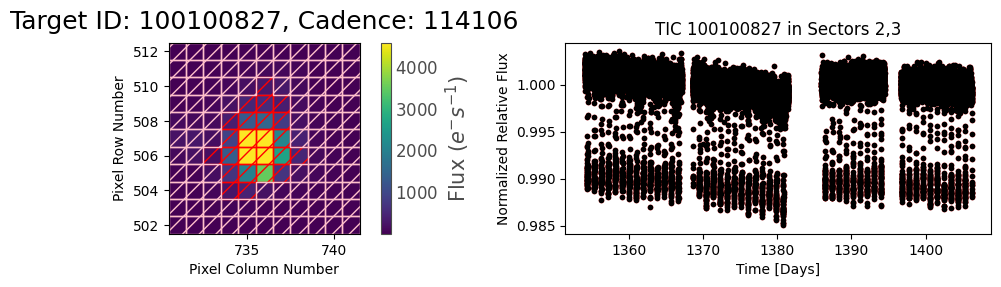

/Users/daxfeliz/Desktop/Mentoring_Teaching/SRMP_project/2024_SRMP/lightcurve_practice_code2.py:543: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
/Users/daxfeliz/Desktop/Mentoring_Teaching/SRMP_project/2024_SRMP/lightcurve_practice_code2.py:544: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
/Users/daxfeliz/Desktop/Mentoring_Teaching/SRMP_project/2024_SRM

BLS period is  0.9415170069651636 d
BLS reference time is 1354.4561526933003
BLS duration is 0.07766657613096012 d



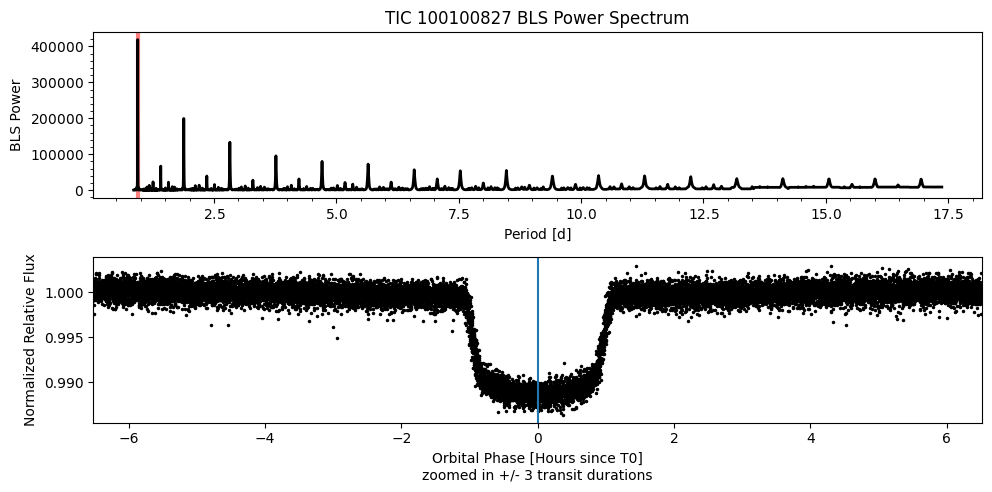

In [42]:
# if you want to run search straight from code keep lines below uncommented, otherwise comment below as noted

# comment this below if you don't want result from code
path= '/Users/daxfeliz/Desktop/Mentoring_Teaching/SRMP_project/2024_SRMP/'
print(path)
import os,sys
sys.path.append(path)
from lightcurve_practice_code2 import pipeline,phasefold_version2
# comment this above if you don't want result from code

starname='TIC 100100827'
# starname='TIC 261136679'#'Pi Mensae'
author='SPOC'
save_directory=os.getcwd()+'/smoothing_practice/'

#selecting photometry settings
mask_threshold=5
nsigma=2
Sector=None

#selecting smoothing settings
window_size_in_days=None
filter_type='biweight'

#selecting period range to search over
min_period=0.5
max_period=27*2/3
# N_periods=10000

#selection duration range to search over
# min_dur=0.05
# max_dur=1
# N_durations=10
oversampling_factor=9
duration_grid_step=1.05
# frequency_factor=500

#debugging mode
verbose=True

#old code
# output_lc, planet_period, planet_t0, planet_dur = pipeline(starname, author, mask_threshold, nsigma, save_directory,
#                                                           window_size_in_days,filter_type,
#                                                           min_period,max_period,N_periods,
#                                                           min_dur, max_dur, N_durations,
#                                                           frequency_factor,verbose)


output_lc, planet_period, planet_t0, planet_dur = pipeline(starname, author, Sector, mask_threshold, 
                                                           nsigma, save_directory,
                                                           window_size_in_days,filter_type,
                                                           min_period,max_period, oversampling_factor,
                                                           duration_grid_step,verbose)

0.9414518 -2778.51837000018


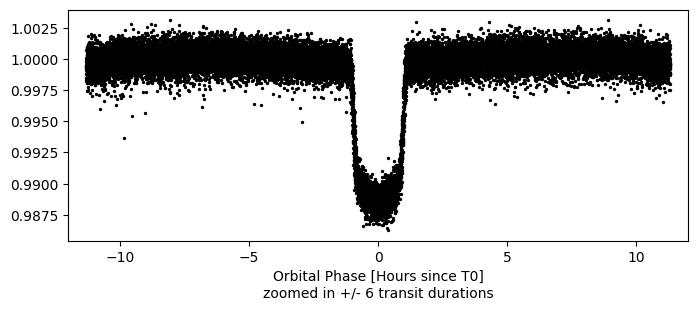

In [53]:
import matplotlib.pyplot as plt
#published results
p,t0 = 0.9414518, 2454221.48163-2457000
print(p,t0)
p,t0 = planet_period, planet_t0

pf,ff,fe = phasefold_version2(output_lc.time.value,output_lc.flux.value,output_lc.flux_err.value,
                          t0,p)
plt.figure(figsize=(8,3))
plt.scatter(24*pf,ff,s=2,color='black')
Ntran_durs=6
plt.xlim(-2*Ntran_durs,2*Ntran_durs)
plt.xlabel('Orbital Phase [Hours since T0]\nzoomed in +/- '+str(Ntran_durs)+' transit durations')

plt.show()